# Imports

In [1]:
import airr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns

import sys
sys.path.append('/mnt/md0/s236922/cowell-lab/repertoire_zoo/')
import repertoire_zoo.bird as br
import repertoire_zoo.giraffe as gr


/home/s236922/apps/miniconda3/envs/zoo/lib/python3.13/site-packages/airr/schema.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream


# Setup Data Directories

In [2]:
# '/mnt/md0/Projects/MonsonLab/COVVAX/vdjserver/a9803592-eaa3-47b5-ac99-d91e8a1434fc-007' <- initial groups defined
# '/mnt/md0/Projects/MonsonLab/COVVAX/vdjserver/1a011c26-48a1-4a2d-8dce-47faa65e1b8b-007' <- more groups

project_id='c0aef9ef-362d-46fd-abba-39ac0945bd66'
job_id='1a011c26-48a1-4a2d-8dce-47faa65e1b8b-007'

data_dir = '/mnt/md0/Projects/MonsonLab/COVVAX/'
repcalc_dir = data_dir + 'vdjserver/'+job_id+'/'
analysis_dir = data_dir + 'analysis/'
fig_dir = analysis_dir + 'figures/'

# Read in Data

In [3]:
sample_info_df = br.read_repertoire_info_airr(repcalc_dir + 'repertoires.airr.json')
repertoire_group_df = br.read_repertoire_group_info_airr(repcalc_dir + 'repertoires.airr.json')

data = airr.read_airr(repcalc_dir + 'repertoires.airr.json')
# pull out repertoires and names
repertoire_groups = { obj['repertoire_group_id'] : obj for obj in data['RepertoireGroup'] }

groups = [
    (repertoire_group_df.loc[i,'repertoire_group_id'], repertoire_group_df.loc[i,'name'], len(repertoire_group_df.loc[i,'repertoires'])) 
    for i in range(len(repertoire_group_df))
]

for rep_group_id in repertoire_groups:
    print(rep_group_id, repertoire_groups[rep_group_id]['repertoire_group_name'])



Total Number of Repertoire Groups:  22
b08f9f20-8770-42e2-a785-ff9443b6edb6 High Neutralization
167ecf28-c395-40ed-9651-a7ef7d0784cb Low Neutralization
ad5489b5-6cff-4773-bb76-ec09b2573ff3 Cat. 1 High Neutralization
08475c9e-efb6-4302-8bb1-77186b5b86b9 Cat. 1 Low Neutralization
1672807c-ba98-4ec4-aa96-e2023c4dd23a Cat. 4-5 High Neutralization
2abdc4e5-dd79-4c39-b7b9-b4e8ee642ec1 Cat. 6 Low Neutralization
fece9f9e-b20e-4df2-bd24-fc4e8cc213d3 Cat. 6 High Neutralization
3621f37f-2b34-478b-af42-ef1fb1f7e799 Cat. 7 High Neutralization
540bc5f1-2a71-4dbc-833f-e01e562e7e03 Cat. 2-7 Low Neutralization
a57c907d-39aa-407c-99df-9c105d43407d Cat. 2-7 High Neutralization
523b4d12-eb73-4a29-bbdd-ebe17576554f Healthy Control
8a1cd1bd-9279-4cb7-883a-1b8ad7f0764f Heme Cancer
d262632b-51d7-49f9-9505-d7ac839f6938 Neuroimmunology
ffb943d1-7afa-484d-88f2-3dd2efc0b102 Solid Cancer
67e77903-4ee3-4e54-9690-acf4a316a7a4 Healthy Control Low Neutralization
3357bc71-0423-495e-9745-b159398e84ec Healthy Control Hig

# Helper Functions

In [4]:
def cat_to_pos(axes:list):
    all_categories = set()
    for ax in axes:
        labels = [tick.get_text() for tick in ax.get_xticklabels()]
        all_categories.update(labels)

    all_categories = sorted(all_categories)

    cat_to_pos = {cat: i for i, cat in enumerate(all_categories)}

    return cat_to_pos, all_categories

def set_sharedx(axes:list):
    cat_pos, all_categories = cat_to_pos(axes)
    for ax in axes:
        ax.set_xlim(-0.5, len(all_categories)-0.5)
        ax.set_xticks(range(len(all_categories)))
        ax.set_xticklabels(all_categories)

def set_sharedy(axes:list):
    y_lims = [ax.get_ylim() for ax in axes]

    y_lim_min = min([y_lim[0] for y_lim in y_lims])
    y_lim_max = max([y_lim[1] for y_lim in y_lims])

    for ax in axes:
        ax.set_ylim((y_lim_min, y_lim_max))

def plot_two_side_by_side(plot1, plot2, figsize=(12, 6), sharey=False, suptitle=None, projection1='rectilinear', projection2='rectilinear'):
    """
    Plots two matplotlib subplots side by side using the given plotting functions.

    Parameters
    ----------
    plot1 : function
        A function that takes a single argument `ax` and plots on it.
    plot2 : function
        A second plotting function like `plot1`.
    figsize : tuple, optional
        Size of the figure, default is (12, 6).
    sharey : bool, optional
        Whether the y-axis should be shared between the plots.
    suptitle : str, optional
        Optional super title for the figure.
    projection1 : str, optional
        The type of projection for the left subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    projection2 : str, optional
        The type of projection for the right subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, height_ratios=[1, 1], figure=fig)

    # Create two PolarAxes manually
    ax1 = fig.add_subplot(gs[0, 0], projection=projection1)
    ax2 = fig.add_subplot(gs[0, 1], projection=projection2)
    axes = [ax1, ax2]
    
    if sharey:
        set_sharedy(axes)
        
    plot1(ax1)
    plot2(ax2)
    
    if suptitle:
        fig.suptitle(suptitle, fontsize=16)
    
    plt.tight_layout()

    return fig, (ax1, ax2)

def plot_three_split_layout(plot_top, plot_bottom_left, plot_bottom_right, figsize=(12, 8), sharex=False, sharey=False, suptitle=None, projection_top:str='rectilinear', projection_bottom_left:str='rectilinear', projection_bottom_right:str='rectilinear'):
    """
    Create a figure with 3 subplots:
    - Top: one plot spanning the top half of the figure.
    - Bottom: two plots side by side.

    Parameters
    ----------
    plot_top : function
        Plotting function that accepts a single `ax` argument for the top plot.
    plot_bottom_left : function
        Plotting function for the bottom-left subplot.
    plot_bottom_right : function
        Plotting function for the bottom-right subplot.
    figsize : tuple, optional
        Size of the figure, default is (12, 8).
    sharex : bool, optional
        Whether the x-axis should be shared between the plots.
    sharey : bool, optional
        Whether the y-axis should be shared between the plots.
    suptitle : str, optional
        Optional super title for the figure.
    projection_top : str, optional
        The type of projection for the top subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    projection_bottom_left : str, optional
        The type of projection for the bottom left subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    projection_bottom_right : str, optional
        The type of projection for the bottom right subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, height_ratios=[1, 1], figure=fig)

    ax_top = fig.add_subplot(gs[0, :], projection=projection_top)       # spans both columns
    ax_bottom_left = fig.add_subplot(gs[1, 0], projection=projection_bottom_left)
    ax_bottom_right = fig.add_subplot(gs[1, 1], projection=projection_bottom_right)
    axes = [ax_top, ax_bottom_left, ax_bottom_right]

    if sharey:
        set_sharedy(axes)

    plot_top(ax_top)
    plot_bottom_left(ax_bottom_left)
    plot_bottom_right(ax_bottom_right)

    if suptitle:
        fig.suptitle(suptitle, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle

    return fig, (ax_top, ax_bottom_left, ax_bottom_right)

def plot_two_by_two_layout(plot_top_left, plot_top_right, plot_bottom_left, plot_bottom_right, figsize=(12, 12), sharey=False, suptitle=None, projection_top_left:str='rectilinear', projection_top_right:str='rectilinear', projection_bottom_left:str='rectilinear', projection_bottom_right:str='rectilinear'):
    """
    Create a figure with 3 subplots:
    - Top: one plot spanning the top half of the figure.
    - Bottom: two plots side by side.

    Parameters
    ----------
    plot_top : function
        Plotting function that accepts a single `ax` argument for the top plot.
    plot_bottom_left : function
        Plotting function for the bottom-left subplot.
    plot_bottom_right : function
        Plotting function for the bottom-right subplot.
    figsize : tuple, optional
        Size of the figure, default is (12, 8).
    suptitle : str, optional
        Optional super title for the figure.
    projection_top_left : str, optional
        The type of projection for the top subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    projection_top_right : str, optional
        The type of projection for the top subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    projection_bottom_left : str, optional
        The type of projection for the bottom left subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    projection_bottom_right : str, optional
        The type of projection for the bottom right subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, height_ratios=[1, 1], figure=fig)

    ax_top_left = fig.add_subplot(gs[0, 0], projection=projection_top_left)
    ax_top_right = fig.add_subplot(gs[0, 1], projection=projection_top_right)
    ax_bottom_left = fig.add_subplot(gs[1, 0], projection=projection_bottom_left)
    ax_bottom_right = fig.add_subplot(gs[1, 1], projection=projection_bottom_right)
    axes = [ax_top_left, ax_top_right, ax_bottom_left, ax_bottom_right]

    plot_top_right(ax_top_right)
    plot_top_left(ax_top_left)
    plot_bottom_left(ax_bottom_left)
    plot_bottom_right(ax_bottom_right)
    
    if sharey:
        set_sharedy(axes)

    if suptitle:
        fig.suptitle(suptitle, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle

    return fig, (ax_top_left, ax_top_right, ax_bottom_left, ax_bottom_right)

def plot_four_vertical_layout(plot1, plot2, plot3, plot4, figsize=(12, 8), sharey=False, suptitle=None, projection1:str='rectilinear', projection2:str='rectilinear', projection3:str='rectilinear', projection4:str='rectilinear'):
    """
    Create a figure with 3 subplots:
    - Top: one plot spanning the top half of the figure.
    - Bottom: two plots side by side.

    Parameters
    ----------
    plot1 : function
        Plotting function that accepts a single `ax` argument for the top plot.
    plot2 : function
        Plotting function that accepts a single `ax` argument for the top plot.
    plot3 : function
        Plotting function that accepts a single `ax` argument for the top plot.
    plot4 : function
        Plotting function that accepts a single `ax` argument for the top plot.
    figsize : tuple, optional
        Size of the figure, default is (12, 8).
    # sharex : bool, optional
    #     Whether the x-axis should be shared between the plots.
    sharey : bool, optional
        Whether the y-axis should be shared between the plots.
    suptitle : str, optional
        Optional super title for the figure.
    projection1 : str, optional
        The type of projection for the top subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    projection2 : str, optional
        The type of projection for the top subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    projection3 : str, optional
        The type of projection for the top subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    projection4 : str, optional
        The type of projection for the top subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(4, 1, figure=fig)

    ax1 = fig.add_subplot(gs[0, :], projection=projection1)
    ax2 = fig.add_subplot(gs[1, :], projection=projection2)
    ax3 = fig.add_subplot(gs[2, :], projection=projection3)
    ax4 = fig.add_subplot(gs[3, :], projection=projection4)
    axes = [ax1, ax2, ax3, ax4]

    plot1(ax1)
    plot2(ax2)
    plot3(ax3)
    plot4(ax4)

    if sharey:
        set_sharedy(axes)

    if suptitle:
        fig.suptitle(suptitle, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle

    return fig, (ax1, ax2, ax3, ax4)

def plot_four_horizontal_layout(plot1, plot2, plot3, plot4, figsize=(12, 8), sharey=False, suptitle=None, projection1:str='rectilinear', projection2:str='rectilinear', projection3:str='rectilinear', projection4:str='rectilinear'):
    """
    Create a figure with 3 subplots:
    - Top: one plot spanning the top half of the figure.
    - Bottom: two plots side by side.

    Parameters
    ----------
    plot1 : function
        Plotting function that accepts a single `ax` argument for the top plot.
    plot2 : function
        Plotting function that accepts a single `ax` argument for the top plot.
    plot3 : function
        Plotting function that accepts a single `ax` argument for the top plot.
    plot4 : function
        Plotting function that accepts a single `ax` argument for the top plot.
    figsize : tuple, optional
        Size of the figure, default is (12, 8).
    # sharex : bool, optional
    #     Whether the x-axis should be shared between the plots.
    sharey : bool, optional
        Whether the y-axis should be shared between the plots.
    suptitle : str, optional
        Optional super title for the figure.
    projection1 : str, optional
        The type of projection for the top subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    projection2 : str, optional
        The type of projection for the top subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    projection3 : str, optional
        The type of projection for the top subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    projection4 : str, optional
        The type of projection for the top subplot. Commonly used is `rectilinear` and `polar`. (Deafult: `rectilinear`.)
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(1, 4, figure=fig)

    ax1 = fig.add_subplot(gs[:, 0], projection=projection1)
    ax2 = fig.add_subplot(gs[:, 1], projection=projection2)
    ax3 = fig.add_subplot(gs[:, 2], projection=projection3)
    ax4 = fig.add_subplot(gs[:, 3], projection=projection4)
    axes = [ax1, ax2, ax3, ax4]

    plot1(ax1)
    plot2(ax2)
    plot3(ax3)
    plot4(ax4)

    if sharey:
        set_sharedy(axes)

    if suptitle:
        fig.suptitle(suptitle, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle

    return fig, (ax1, ax2, ax3, ax4)

# Setup Colormaps

In [5]:
cmap = mpl.colormaps['nipy_spectral'] # gist_rainbow
cmin = 0.0
cmax = 1.0

# V
v_genes = br.load_gene_usage_group_data(
    repcalc_dir=repcalc_dir,
    groups=groups,
    processing_stage='igblast.makedb.gene.clone',
    call_type='v_call',
    level='gene'
)['gene'].unique()
v_genes_cmap = {
    v_gene : cmap(np.linspace(cmin,cmax,len(v_genes))[i])
    for i, v_gene in enumerate(v_genes)
}

v_subgroups = br.load_gene_usage_group_data(
    repcalc_dir=repcalc_dir,
    groups=groups,
    processing_stage='igblast.makedb.gene.clone',
    call_type='v_call',
    level='subgroup'
)['gene'].unique()
v_subgroup_cmap = {
    v_subgroup : cmap(np.linspace(cmin,cmax,len(v_subgroups))[i])
    for i, v_subgroup in enumerate(v_subgroups)
}

# J
j_genes = br.load_gene_usage_group_data(
    repcalc_dir=repcalc_dir,
    groups=groups,
    processing_stage='igblast.makedb.gene.clone',
    call_type='j_call',
    level='gene'
)['gene'].unique()
j_genes_cmap = {
    j_gene : cmap(np.linspace(cmin,cmax,len(j_genes))[i])
    for i, j_gene in enumerate(j_genes)
}

j_subgroups = br.load_gene_usage_group_data(
    repcalc_dir=repcalc_dir,
    groups=groups,
    processing_stage='igblast.makedb.gene.clone',
    call_type='j_call',
    level='subgroup'
)['gene'].unique()
j_subgroup_cmap = {
    j_subgroup : cmap(np.linspace(cmin,cmax,len(j_subgroups))[i])
    for i, j_subgroup in enumerate(j_subgroups)
}

# cond_cmap
conds = br.load_and_prepare_data_junction_aa(
    repcalc_dir=repcalc_dir,
    groups=groups,
    processing_stage='.igblast.makedb.allele.clone.group.',
    call_type='junction_aa_length'
)['condition'].unique()
cond_cmap = {
    cond : cmap(np.linspace(cmin,cmax,len(conds))[i])
    for i, cond in enumerate(conds)
}


# Functionality

## Gene Usage

In [6]:
threshold = 0.05
ylim_mult = 0.8

df = br.load_gene_usage_group_data(
    repcalc_dir=repcalc_dir,
    groups=groups,
    processing_stage='igblast.makedb.gene.clone',
    call_type='v_call',
    level='subgroup'
)

# pd.set_option("display.max_rows", None)
pd.set_option("display.max_rows", 10)
df

gene  duplicate_frequency_avg  duplicate_frequency_std      N  \
0    IGHV1                 0.162504                 0.119946    8.0   
1    IGHV1                 0.098256                 0.034655    5.0   
2    IGHV1                 0.127970                 0.069410  142.0   
3    IGHV1                 0.149067                 0.090822    9.0   
4    IGHV1                 0.114738                 0.063082   40.0   
..     ...                      ...                      ...    ...   
149  IGLV1                 0.000002                 0.000022  142.0   
150  IGLV1                 0.000004                 0.000031   72.0   
151  IGLV1                 0.000002                 0.000021  150.0   
152  IGLV1                 0.000003                 0.000026   98.0   
153  IGLV1                 0.000003                 0.000027   90.0   

                            condition  
0          Cat. 1 High Neutralization  
1           Cat. 1 Low Neutralization  
2        Cat. 2-7 High Neutralization  
3         Cat. 2-7 Low Neutralization  
4        Cat. 4-5 High Neutralization  
..                                ...  
149      Cat. 2-7 High Neutralization  
150        Cat. 6 High Neutralization  
151               High Neutralization  
152                      Solid Cancer  
153  Solid Cancer High Neutralization  

[154 rows x 5 columns]

(np.float64(0.04000000000000001), np.float64(0.48150312531831374))
(np.float64(0.04000000000000001), np.float64(0.5725070649084875))
(np.float64(0.04000000000000001), np.float64(0.48115821030984696))
(np.float64(0.04000000000000001), np.float64(0.4832243902003671))


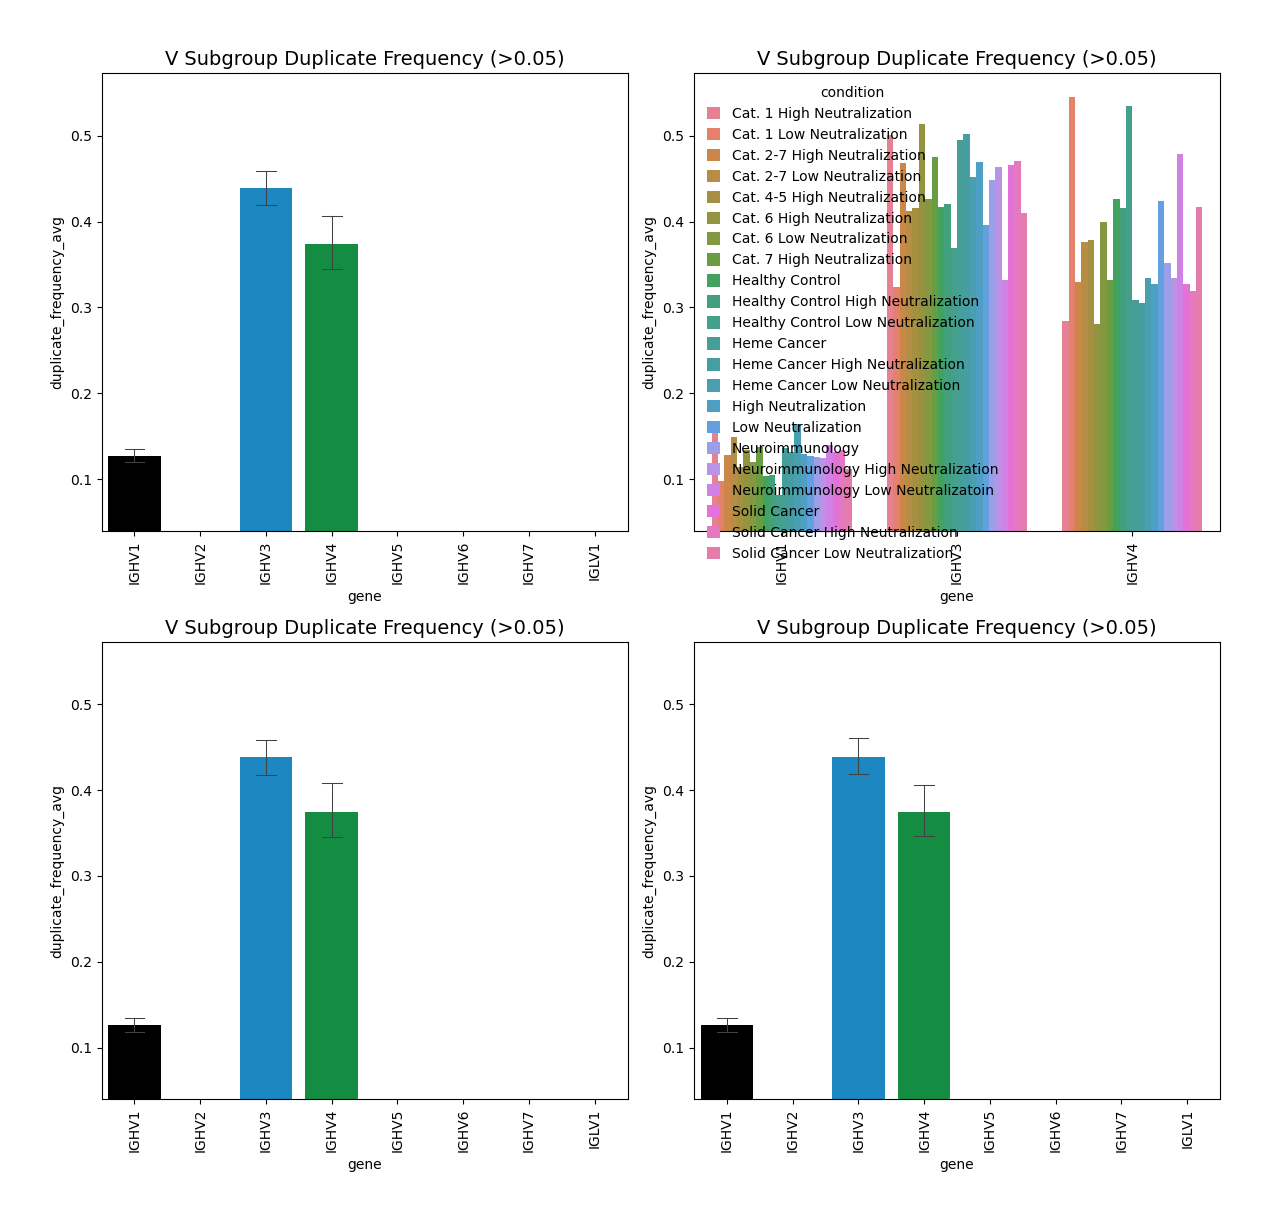

(<Figure size 1200x1200 with 4 Axes>,
 (<Axes: title={'center': 'V Subgroup Duplicate Frequency (>0.05)'}, xlabel='gene', ylabel='duplicate_frequency_avg'>,
  <Axes: title={'center': 'V Subgroup Duplicate Frequency (>0.05)'}, xlabel='gene', ylabel='duplicate_frequency_avg'>,
  <Axes: title={'center': 'V Subgroup Duplicate Frequency (>0.05)'}, xlabel='gene', ylabel='duplicate_frequency_avg'>,
  <Axes: title={'center': 'V Subgroup Duplicate Frequency (>0.05)'}, xlabel='gene', ylabel='duplicate_frequency_avg'>))

In [7]:
threshold = 0.05
ylim_mult = 0.8

df = br.load_gene_usage_group_data(
    repcalc_dir=repcalc_dir,
    groups=groups,
    processing_stage='igblast.makedb.gene.clone',
    call_type='v_call',
    level='subgroup'
)

# V Duplicate Frequency
def plot1(ax):
    gr.plot_duplicate_frequency(
        df=df,
        hue_order=None,
        palette=v_subgroup_cmap,
        threshold=threshold,
        title='V Subgroup Duplicate Frequency (>0.05)',
        ylim=(threshold*ylim_mult, None),
        ax=ax
    )

# split by Cat
def plot2(ax):
    gr.plot_duplicate_frequency(
        df=df,
        hue_order=None,
        palette=v_subgroup_cmap,
        threshold=threshold,
        title='V Subgroup Duplicate Frequency (>0.05)',
        ylim=(threshold*ylim_mult, None),
        split=True,
        ax=ax
    )

# std dev
def plot3(ax):
    gr.plot_duplicate_frequency(
        df=df,
        hue_order=None,
        palette=v_subgroup_cmap,
        threshold=threshold,
        title='V Subgroup Duplicate Frequency (>0.05)',
        ylim=(threshold*ylim_mult, None),
        errorbar=True,
        ax=ax
    )

# data points
def plot4(ax):
    gr.plot_duplicate_frequency(
        df=df,
        hue_order=None,
        palette=v_subgroup_cmap,
        threshold=threshold,
        title='V Subgroup Duplicate Frequency (>0.05)',
        ylim=(threshold*ylim_mult, None),
        datapoints=True,
        ax=ax
    )

# plot_two_side_by_side(plot1, plot2)
plot_two_by_two_layout(plot1, plot2, plot3, plot4, sharey=True)

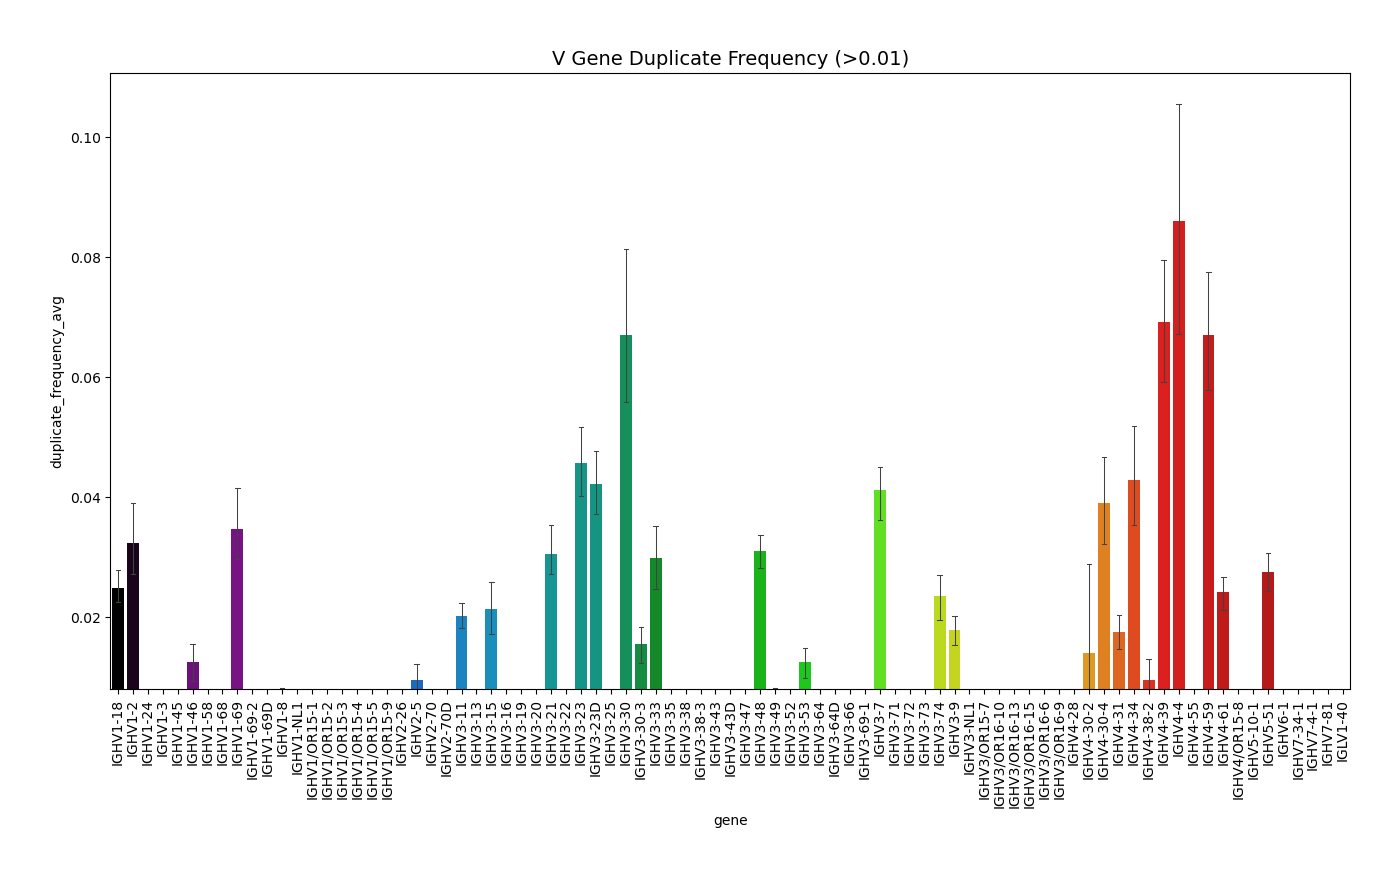

In [18]:
threshold = 0.01
ylim_mult = 0.8

df = br.load_gene_usage_group_data(
    repcalc_dir=repcalc_dir,
    groups=groups,
    processing_stage='igblast.makedb.gene.clone',
    call_type='v_call',
    level='gene'
)

fig, ax = gr.plot_duplicate_frequency(
    df=df,
    hue_order=None,
    palette=v_genes_cmap,
    threshold=threshold,
    title=f'V Gene Duplicate Frequency (>{threshold})',
    ylim=(ylim_mult*threshold, None)
)

fig.show()

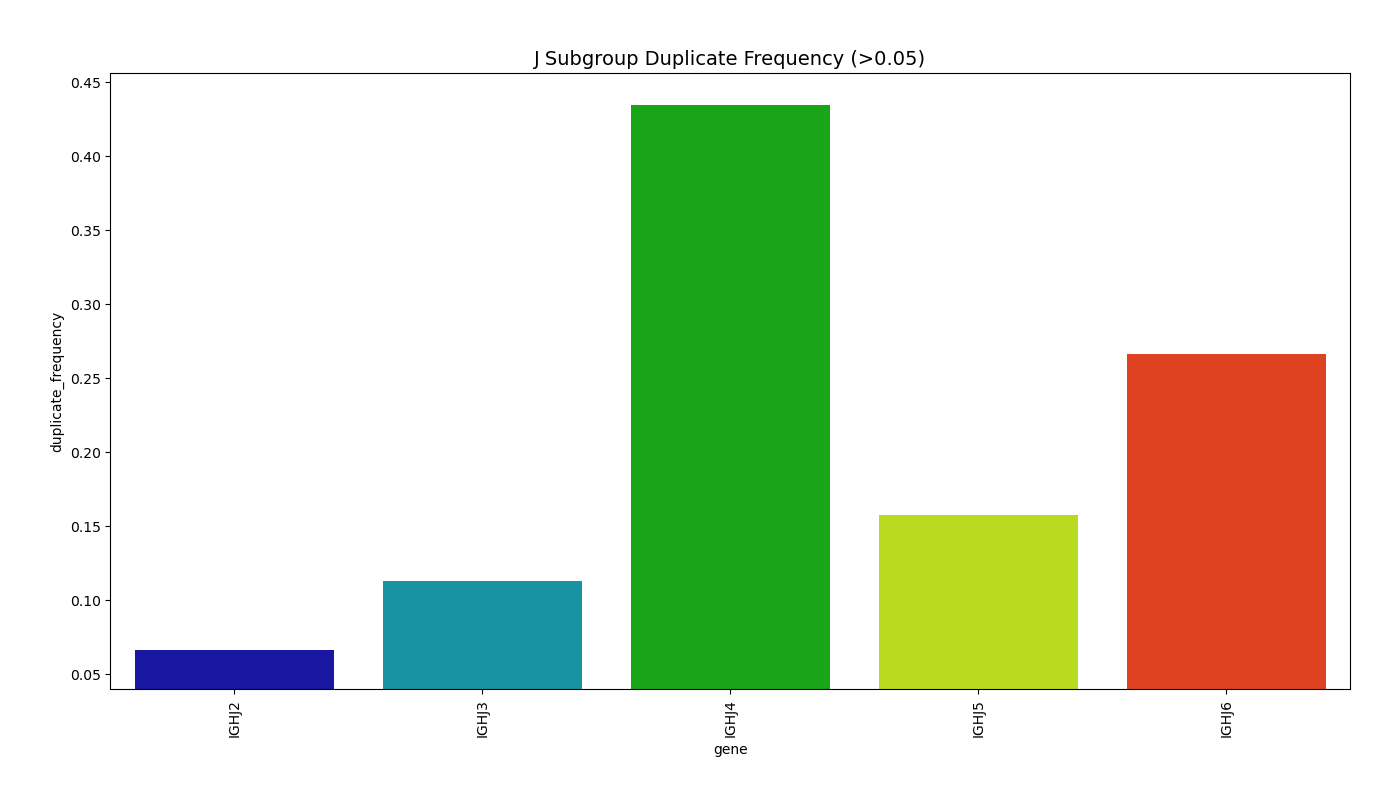

In [24]:
threshold = 0.05
ylim_mult = 0.8

df = br.load_gene_usage_group_data(
    repcalc_dir=repcalc_dir,
    groups=groups,
    processing_stage='igblast.makedb.gene.clone',
    call_type='j_call',
    level='subgroup'
)

fig, ax = gr.plot_duplicate_frequency(
    df=df,
    hue_order=None,
    palette=j_subgroup_cmap,
    threshold=threshold,
    title=f'J Subgroup Duplicate Frequency (>{threshold})',
    ylim=(threshold*ylim_mult, None)
)

fig.show()

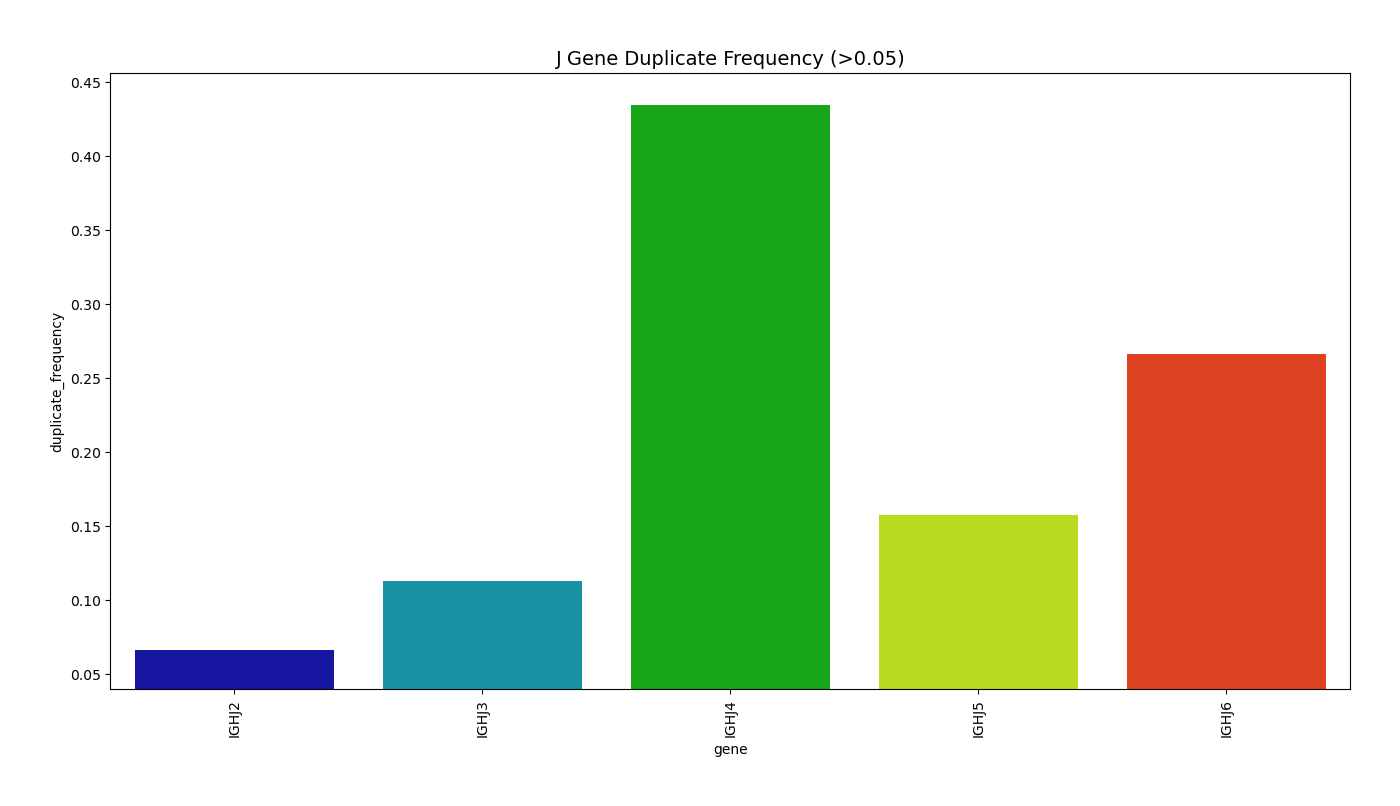

In [25]:
threshold = 0.05
ylim_mult = 0.8

df = br.load_gene_usage_group_data(
    repcalc_dir=repcalc_dir,
    groups=groups,
    processing_stage='igblast.makedb.gene.clone',
    call_type='j_call',
    level='gene'
)

fig, ax = gr.plot_duplicate_frequency(
    df=df,
    hue_order=None,
    palette=j_genes_cmap,
    threshold=0.05,
    title=f'J Gene Duplicate Frequency (>{threshold})',
    ylim=(threshold*ylim_mult, None)
)

fig.show()

## Junction AA Length

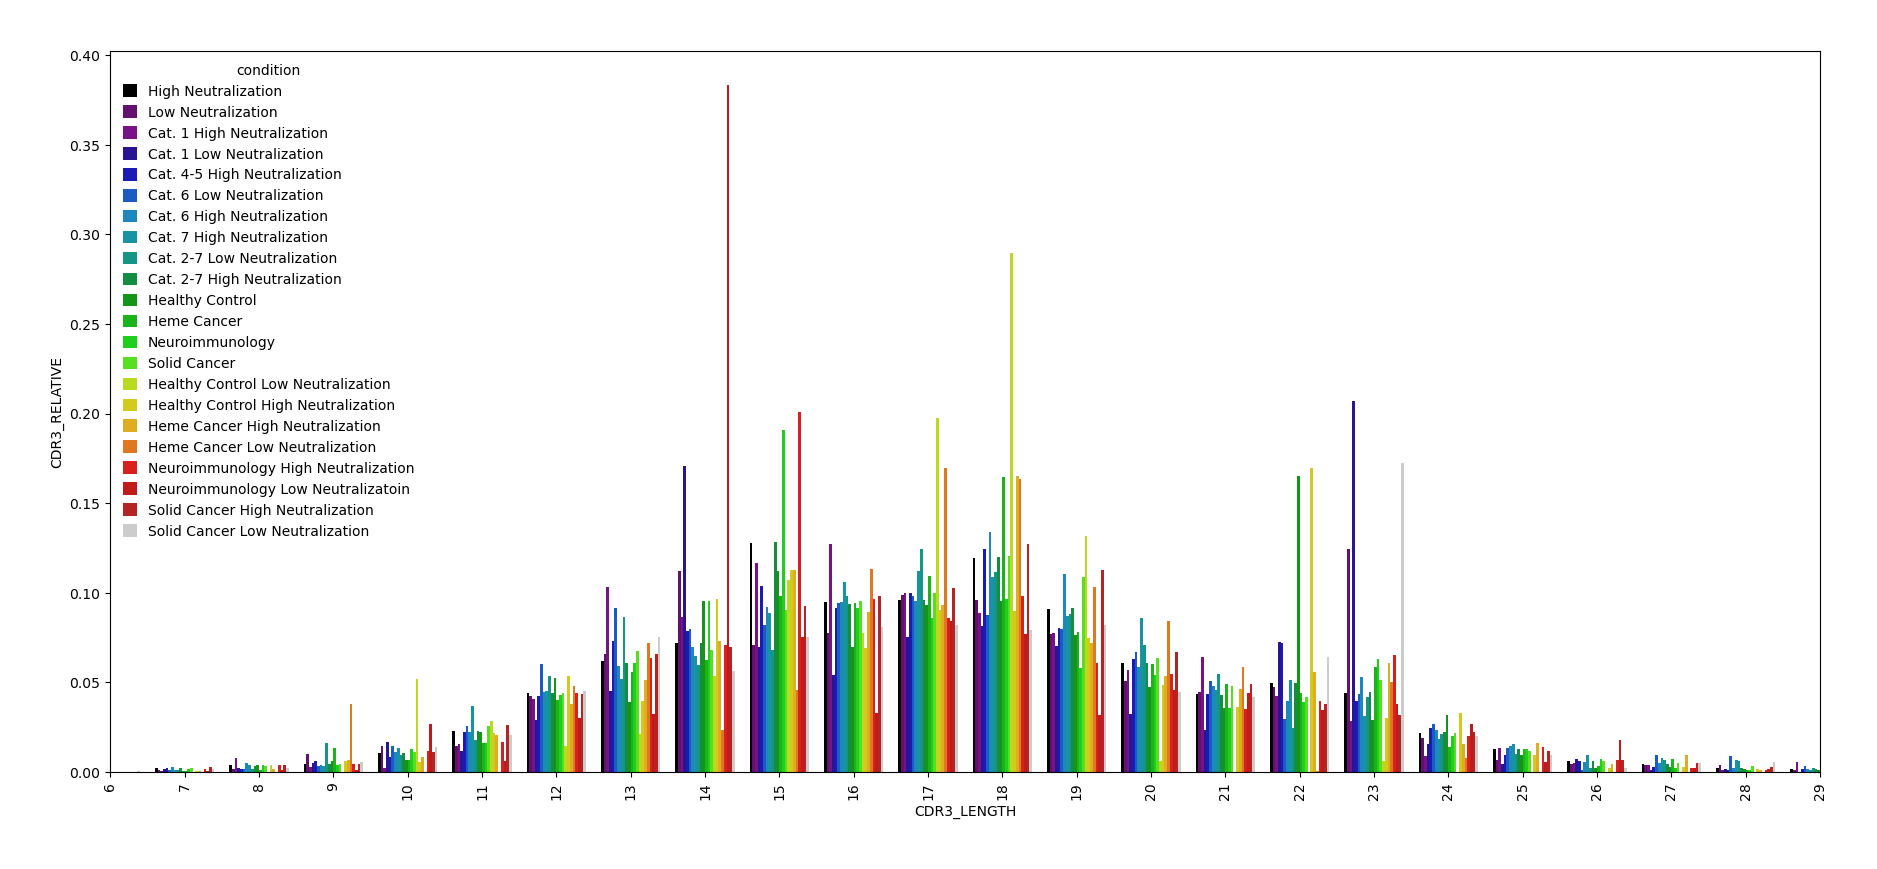

In [19]:
df = br.load_and_prepare_data_junction_aa(
    repcalc_dir=repcalc_dir,
    groups=groups,
    processing_stage='.igblast.makedb.allele.clone.group.',
    call_type='junction_aa_length'
)

fig, ax = gr.plot_junction_aa_length(
    df=df,
    x_col='CDR3_LENGTH',
    y_col='CDR3_RELATIVE',
    hue_col='condition',
    palette=cond_cmap
)

fig.show()

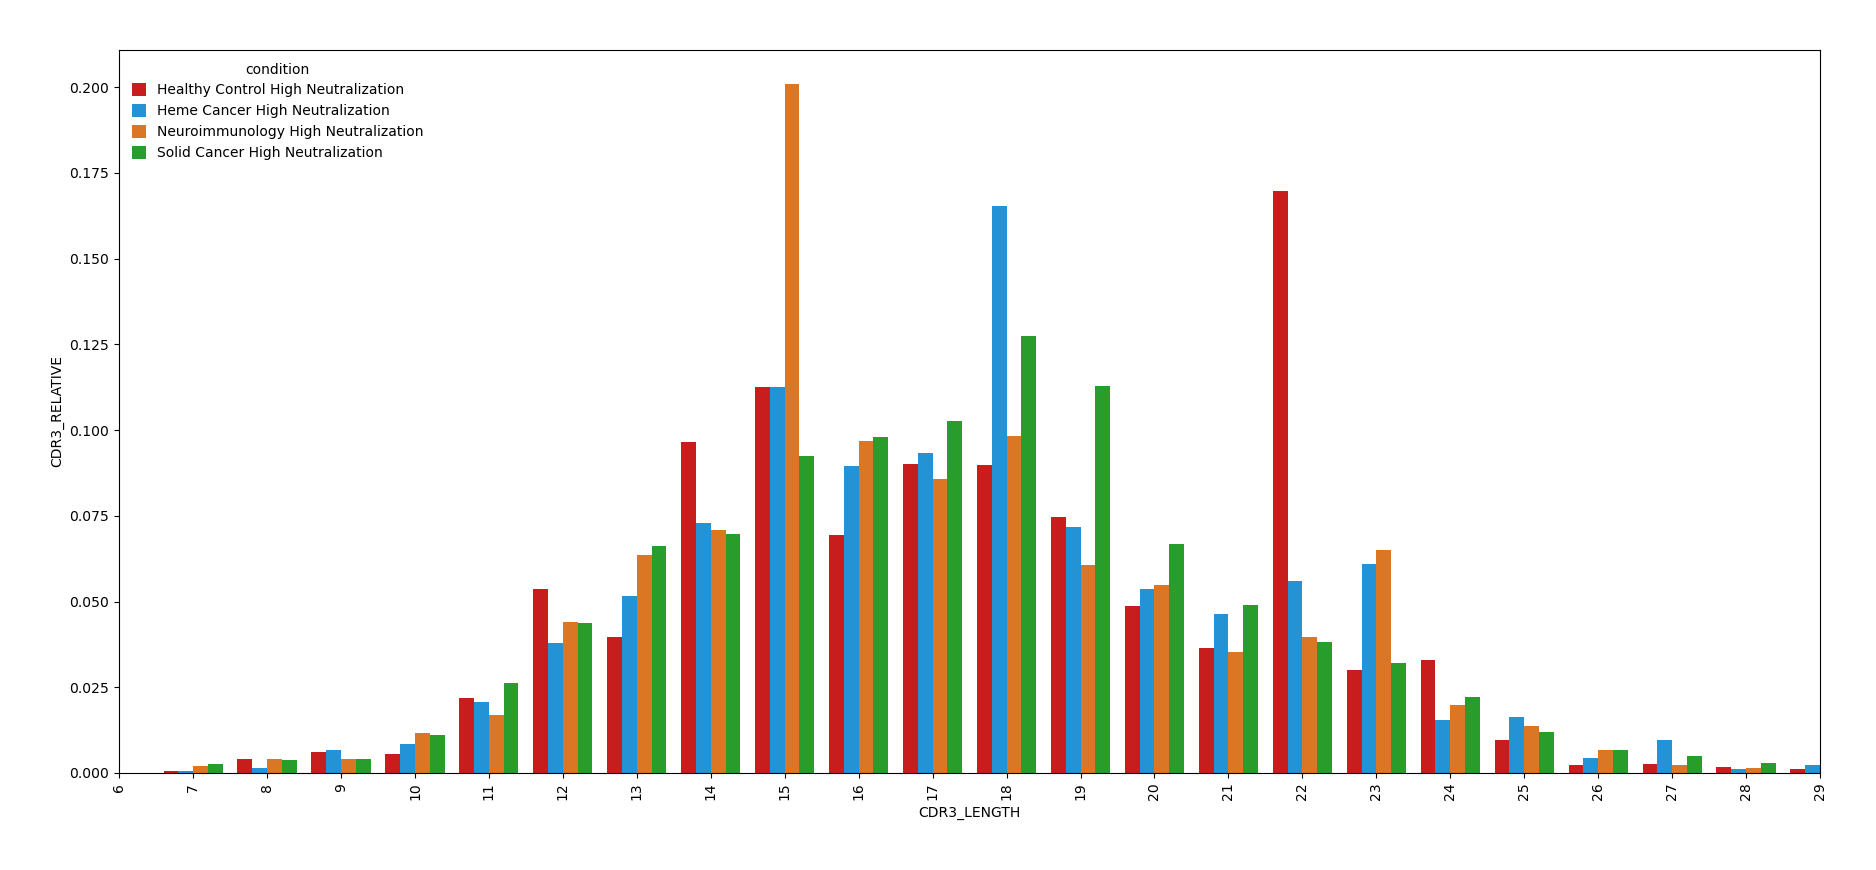

In [36]:
df = br.load_and_prepare_data_junction_aa(
    repcalc_dir=repcalc_dir,
    groups=diag_hi_groups,
    processing_stage='.igblast.makedb.allele.clone.group.',
    call_type='junction_aa_length'
)

fig, ax = gr.plot_junction_aa_length(
    df=df,
    x_col='CDR3_LENGTH',
    y_col='CDR3_RELATIVE',
    hue_col='condition',
    palette=['xkcd:red', 'xkcd:azure', 'xkcd:orange', 'xkcd:green']
)

fig.show()

## VJ Combo Chord Diagram

In [ ]:
for group_id, group_name in groups:
    df = br.load_and_prepare_data_vj_combo(
        repcalc_dir=repcalc_dir,
        group_id=group_id,
        combo_type='vj_combo',
        processing_stage='.igblast.makedb.group.'
    )

    fig, ax = gr.plot_vj_chord_diagram(
        df=df,
        freq_col='duplicate_frequency_avg',
        ticks_interval=0.02,
        max_links=None,
        cmap=v_subgroup_cmap | j_subgroup_cmap,
        title=group_name+' VJ Chord Diagram'
    )
    
    fig.show()

    break


## V Gene Duplicate Frequency

gene                        83
duplicate_frequency        145
duplicate_frequency_avg    154
duplicate_frequency_std    154
condition                    2
dtype: int64

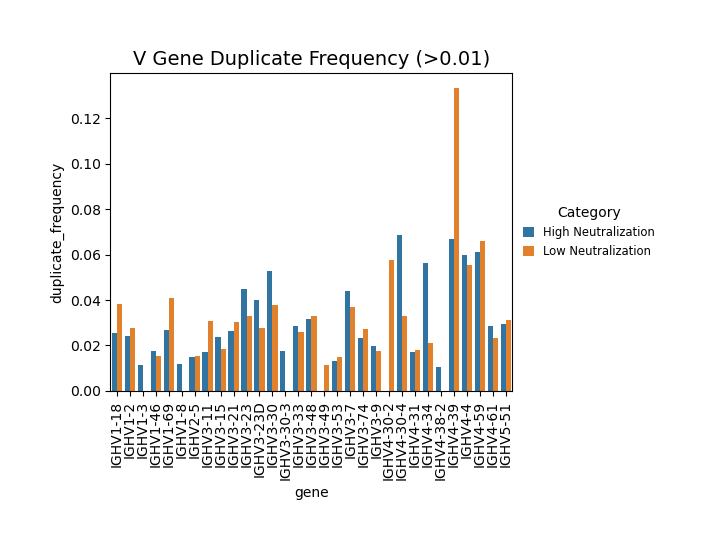

In [23]:
fig, ax = plt.subplots(1,1)

# V dup freq
threshold = 0.01
ylim_mult = 0

df = br.load_gene_usage_group_data(
    repcalc_dir=repcalc_dir,
    groups=groups[0:2],
    processing_stage='igblast.makedb.gene.clone',
    call_type='v_call',
    level='gene'
)

gr.plot_duplicate_frequency(
    df=df,
    palette=v_genes_cmap,
    threshold=threshold,
    title=f'V Gene Duplicate Frequency (>{threshold})',
    ylim=(ylim_mult*threshold, None),
    ax=ax,
    split=True
)

fig.show()
df.nunique()


## Mutational Data

In [ ]:
for group_id, group_name in groups:
    df = br.load_and_prepare_mutation_data(
        mutation_data_dir=repcalc_dir,
        group_id=group_id,
        trim_codons=16,
        processing_stage='igblast.makedb.gene.clone.mutations'
    )
    
    fig, ax = gr.plot_mutational_hedgehog(
        df=df,
        figsize=(12,12),
        title=f'Mutational HedgeHog for group: {group_name}',
    )

    fig.show()

    break

In [ ]:
df.head()

## Multi plots

### Duplicate Freqeuncy & VJ Chord Diagram

In [ ]:
for i, (group_id, group_name) in enumerate(groups):

    if i!=0:
        small_group = [
            (prev_group_id, prev_group_name),
            (group_id, group_name)
        ]

        def plot_top_left(ax):
            # V dup freq
            threshold = 0.01
            ylim_mult = 0

            df = br.load_gene_usage_group_data(
                repcalc_dir=repcalc_dir,
                groups=small_group,
                processing_stage='igblast.makedb.gene.clone',
                call_type='v_call',
                level='subgroup'
            )

            gr.plot_duplicate_frequency(
                df=df,
                threshold=threshold,
                title=f'V Gene Duplicate Frequency (>{threshold})',
                ylim=(ylim_mult*threshold, None),
                ax=ax,
                split=True
            )

        def plot_top_right(ax):
            threshold = 0.05
            ylim_mult = 0

            df = br.load_gene_usage_group_data(
                repcalc_dir=repcalc_dir,
                groups=small_group,
                processing_stage='igblast.makedb.gene.clone',
                call_type='j_call',
                level='subgroup'
            )

            gr.plot_duplicate_frequency(
                df=df,
                threshold=0.05,
                title=f'J Gene Duplicate Frequency (>{threshold})',
                ylim=(threshold*ylim_mult, None),
                ax=ax,
                split=True
            )

        def plot_bottom_left(ax):
            df = br.load_and_prepare_data_vj_combo(
                repcalc_dir=repcalc_dir,
                group_id=small_group[0][0],
                combo_type='vj_combo',
                processing_stage='.igblast.makedb.group.'
            )

            gr.plot_vj_chord_diagram(
                df=df,
                freq_col='duplicate_frequency_avg',
                ticks_interval=0.02,
                max_links=None,
                cmap=v_subgroup_cmap | j_subgroup_cmap,
                title=small_group[0][1]+' VJ Chord Diagram',
                ax=ax
            )

        def plot_bottom_right(ax):
            df = br.load_and_prepare_data_vj_combo(
                repcalc_dir=repcalc_dir,
                group_id=small_group[1][0],
                combo_type='vj_combo',
                processing_stage='.igblast.makedb.group.'
            )

            gr.plot_vj_chord_diagram(
                df=df,
                freq_col='duplicate_frequency_avg',
                ticks_interval=0.02,
                max_links=None,
                cmap=v_subgroup_cmap | j_subgroup_cmap,
                title=small_group[1][1]+' VJ Chord Diagram',
                ax=ax
            )

        plot_two_by_two_layout(
            plot_top_left,
            plot_top_right,
            plot_bottom_left,
            plot_bottom_right,
            projection_bottom_left='polar',
            projection_bottom_right='polar'
        )

        break

    prev_group_id = group_id
    prev_group_name = group_name

### VJ Chord Diagram & CDR3 length

In [ ]:
for i, (group_id, group_name) in enumerate(groups):

    if i!=0:
        small_group = [
            (prev_group_id, prev_group_name),
            (group_id, group_name)
        ]
        
        def plot1(ax):    
            df = br.load_and_prepare_data_junction_aa(
                repcalc_dir=repcalc_dir,
                groups=small_group,
                processing_stage='.igblast.makedb.allele.clone.group.',
                call_type='junction_aa_length'
            )

            gr.plot_junction_aa_length(
                df=df,
                x_col='CDR3_LENGTH',
                y_col='CDR3_RELATIVE',
                hue_col='condition',
                ax=ax,
                aa_range=(6,26)
            )

        def plot2(ax):
            df = br.load_and_prepare_data_vj_combo(
                repcalc_dir=repcalc_dir,
                group_id=prev_group_id,
                combo_type='vj_combo',
                processing_stage='.igblast.makedb.group.'
            )

            gr.plot_vj_chord_diagram(
                df=df,
                freq_col='duplicate_frequency_avg',
                ticks_interval=0.02,
                max_links=None,
                cmap=v_subgroup_cmap | j_subgroup_cmap,
                title=prev_group_name+' VJ Chord Diagram',
                ax=ax
            )
        
        def plot3(ax):
            df = br.load_and_prepare_data_vj_combo(
                repcalc_dir=repcalc_dir,
                group_id=group_id,
                combo_type='vj_combo',
                processing_stage='.igblast.makedb.group.'
            )

            gr.plot_vj_chord_diagram(
                df=df,
                freq_col='duplicate_frequency_avg',
                ticks_interval=0.02,
                max_links=None,
                cmap=v_subgroup_cmap | j_subgroup_cmap,
                title=group_name+' VJ Chord Diagram',
                ax=ax
            )
    
    if i!=0:
        if i==1:
            fig, axes = plot_two_side_by_side(plot2, plot3, figsize=(12, 8), sharey=True, suptitle=None, projection1='polar', projection2='polar')
            fig.show()
        fig, axes = plot_three_split_layout(plot1, plot2, plot3, figsize=(12, 12), suptitle=None, projection_bottom_left='polar', projection_bottom_right='polar')
        fig.show()
        break

    prev_group_id = group_id
    prev_group_name = group_name

### V/J Call Gene Usage & Duplicate Frequency

In [ ]:
for i, (group_id, group_name) in enumerate(groups):

    if i!=0:
        small_group = [
            (prev_group_id, prev_group_name),
            (group_id, group_name)
        ]

        def plot_top_left(ax):
            # V dup freq
            threshold = 0.01
            ylim_mult = 0

            df = br.load_gene_usage_group_data(
                repcalc_dir=repcalc_dir,
                groups=small_group,
                processing_stage='igblast.makedb.gene.clone',
                call_type='v_call',
                level='gene'
            )

            gr.plot_duplicate_frequency(
                df=df,
                threshold=threshold,
                title=f'V Gene Duplicate Frequency (>{threshold})',
                ylim=(ylim_mult*threshold, None),
                ax=ax,
                split=True
            )

        def plot_top_right(ax):
            threshold = 0.05
            ylim_mult = 0

            df = br.load_gene_usage_group_data(
                repcalc_dir=repcalc_dir,
                groups=small_group,
                processing_stage='igblast.makedb.gene.clone',
                call_type='j_call',
                level='gene'
            )

            gr.plot_duplicate_frequency(
                df=df,
                threshold=0.05,
                title=f'J Gene Duplicate Frequency (>{threshold})',
                ylim=(threshold*ylim_mult, None),
                ax=ax,
                split=True
            )

        def plot_bottom_left(ax):
            df = br.load_and_prepare_data_vj_combo(
                repcalc_dir=repcalc_dir,
                group_id=small_group[0][0],
                combo_type='vj_combo',
                processing_stage='.igblast.makedb.group.'
            )

            gr.plot_vj_chord_diagram(
                df=df,
                freq_col='duplicate_frequency_avg',
                ticks_interval=0.02,
                max_links=None,
                cmap=v_subgroup_cmap | j_subgroup_cmap,
                title=small_group[0][1]+' VJ Chord Diagram',
                ax=ax
            )

        def plot_bottom_right(ax):
            df = br.load_and_prepare_data_vj_combo(
                repcalc_dir=repcalc_dir,
                group_id=small_group[1][0],
                combo_type='vj_combo',
                processing_stage='.igblast.makedb.group.'
            )

            gr.plot_vj_chord_diagram(
                df=df,
                freq_col='duplicate_frequency_avg',
                ticks_interval=0.02,
                max_links=None,
                cmap=v_subgroup_cmap | j_subgroup_cmap,
                title=small_group[1][1]+' VJ Chord Diagram',
                ax=ax
            )

        plot_two_by_two_layout(
            plot_top_left,
            plot_top_right,
            plot_bottom_left,
            plot_bottom_right,
            projection_bottom_left='polar',
            projection_bottom_right='polar'
        )

        break

    prev_group_id = group_id
    prev_group_name = group_name

## Diversity Curves

In [ ]:
dfs = []
for i, (group_id, group_name) in enumerate(groups):
        
    df = br.load_diversity_group_data(
        data_dir=repcalc_dir,
        repertoire_group=repertoire_groups[group_id],
        processing_stage='igblast.makedb.gene.clone'
    )
    dfs.append(df)

# df = br.load_diversity_data(
#     data_dir=repcalc_dir,
#     repertoire_id=repertoire_groups['b08f9f20-8770-42e2-a785-ff9443b6edb6']['repertoires'][0]['repertoire_id'],
#     processing_stage='igblast.makedb.gene.clone'
# )
df = pd.concat(dfs)
fig, ax = gr.plot_diversity_curve(
    df=df
)

df.head()
# fig.show()

## Clonal abundance

In [ ]:
df = br.

fig, ax = gr.plot_clonal_abundance(
    
)

## CDR3

### CDR3 Length

In [19]:
data['Repertoire'][0]['subject']['diagnosis'][0]['study_group_description']

'Solid Cancer'

In [20]:
d = [(d['repertoire_id'], d['subject']['diagnosis'][0]['study_group_description']) for d in data['Repertoire'][0:10]]

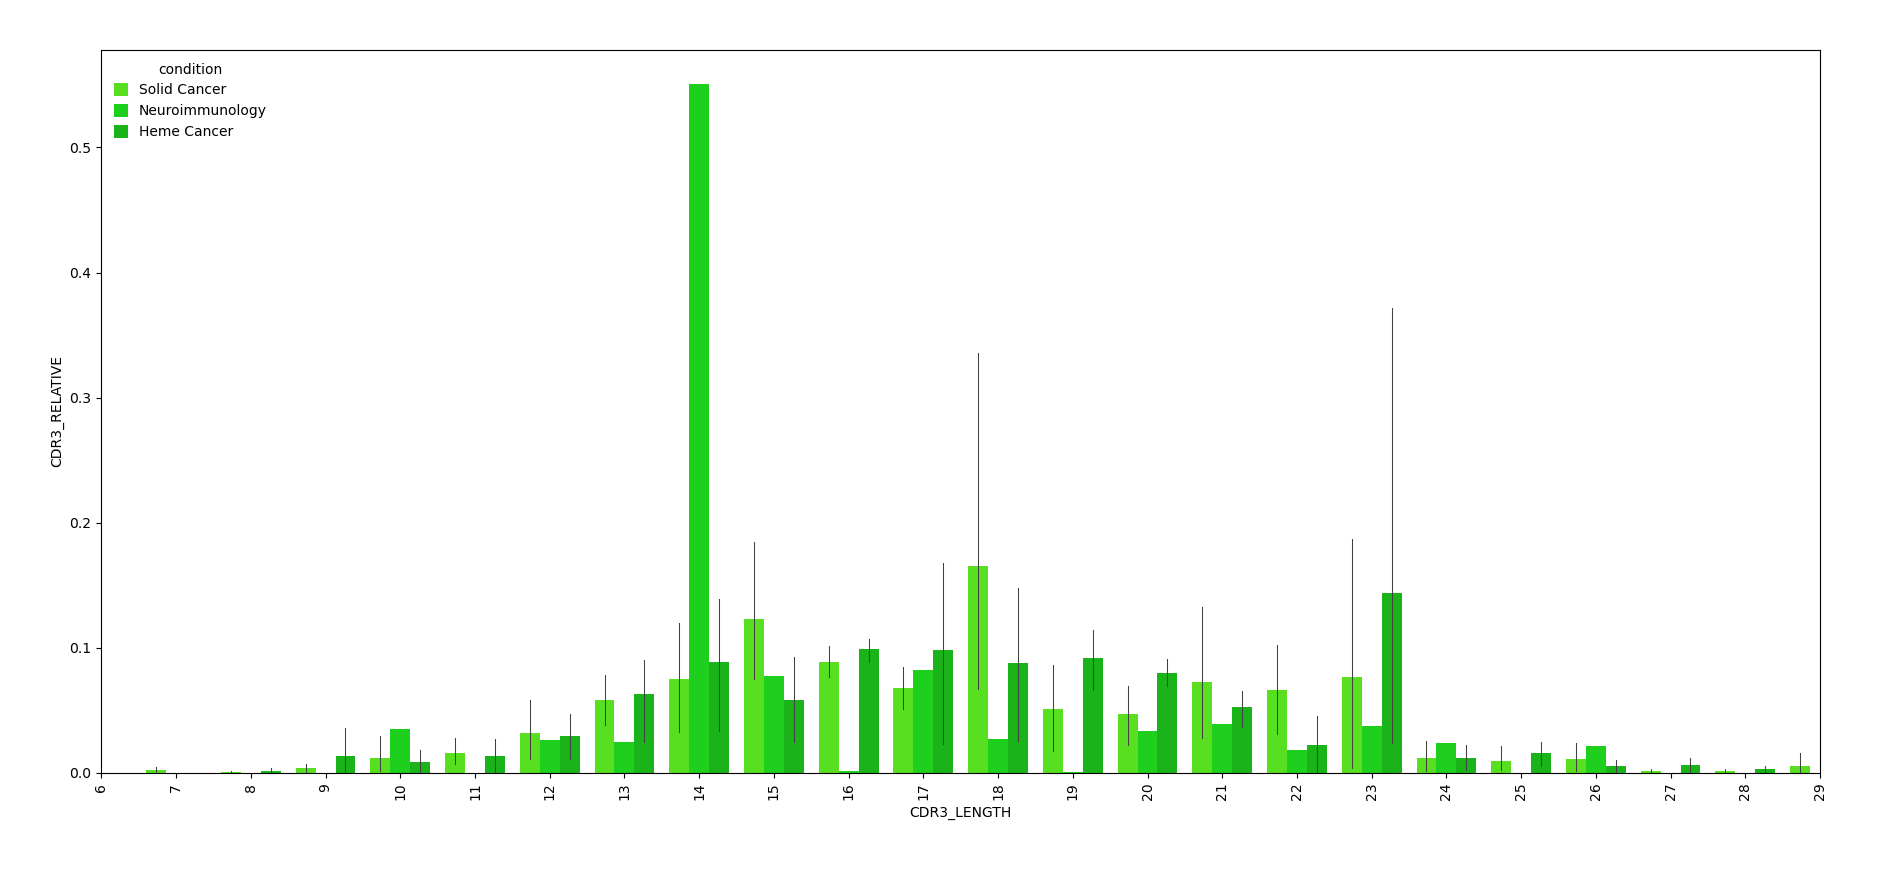

In [43]:
# d = [(d['repertoire_id'], d['subject']['diagnosis'][0]['study_group_description']) for d in data['Repertoire'][0:10]]

df = br.load_and_prepare_data_junction_aa(
    repcalc_dir=repcalc_dir,
    repertoires=None,
    groups=d,
    processing_stage='.igblast.makedb.allele.clone.',
    call_type='junction_aa_length'
)

fig, ax = gr.plot_junction_aa_length(
    df=df,
    x_col='CDR3_LENGTH',
    y_col='CDR3_RELATIVE',
    hue_col='condition',
    palette=cond_cmap
)

fig.show()

# break

In [ ]:
for i, (group_id, group_name) in enumerate(groups):

    df = br.load_and_prepare_data_junction_aa(
        repcalc_dir=repcalc_dir,
        groups=[(group_id, group_name)],
        processing_stage='.igblast.makedb.allele.clone.group.',
        call_type='junction_aa_length'
    )

    fig, ax = gr.plot_junction_aa_length(
        df=df,
        x_col='CDR3_LENGTH',
        y_col='CDR3_RELATIVE',
        hue_col='condition',
        palette=cond_cmap
    )

    fig.show()

    break

In [ ]:
for i, (group_id, group_name) in enumerate(groups):

    df = br.load_and_prepare_data_junction_aa(
        repcalc_dir=repcalc_dir,
        groups=[(group_id, group_name)],
        processing_stage='.igblast.makedb.allele.clone.group.',
        call_type='junction_aa_length'
    )

    fig, ax = gr.plot_junction_aa_length(
        df=df,
        x_col='CDR3_LENGTH',
        y_col='CDR3_RELATIVE',
        hue_col='condition',
        palette=cond_cmap
    )

    fig.show()

    break

### CDR3 AA Sharing Heatmap

In [ ]:
group_names = ['High Neutralization', 'Low Neutralization']
group_names = ['Low Neutralization']

# plot_type = 'between' if len(groups) == 2 else 'within'
plot_type = 'between'

sharing = 'cdr3_aa_sharing'
processing_stage = 'repertoire.shared.matrix'

similarity_metric = 'a_in_b' #jaccard, simpson_coefficient, a_in_b, b_in_a
# similarity_metric = 'b_in_a' #jaccard, simpson_coefficient, a_in_b, b_in_a
percentage = True
for i, group in enumerate(groups): # group = group_id, group_name/cond
    if i!=0:
        matrix = br.load_shared_cdr3_aa_data(
            repcalc_dir,
            repertoire_groups, 
            sample_info_df, 
            groups=[prev_group, group], 
            percentage=percentage,
            similarity_metric=similarity_metric,
            sharing=sharing,
            processing_stage=processing_stage,
            plot_type=plot_type
        )
        matrix = matrix.sort_index().sort_index(axis=1)
        fig, ax = gr.plot_cdr3_aa_sharing_heatmap(matrix, cmap = 'viridis', figsize = (36, 30))
        plt.title(f"Heatmap of {sharing} {plot_type} group")
        plt.tight_layout()
    else:
        prev_group = group
    if i==1:
        break

### CDR3 AA Sharing Group Summary

In [ ]:
data['RepertoireGroup'][0]['repertoire_group_name']

In [ ]:
[rep_id['repertoire_id'] for rep_id in data['RepertoireGroup'][0]['repertoires']]

In [ ]:
groups

In [ ]:
# plot_type = 'between' if len(groups) == 2 else 'within'
plot_type = 'between'

sharing = 'cdr3_aa_sharing'
processing_stage = 'group.summary_comparison'

for i, group in enumerate(groups): # group = group_id, group_name/cond
    if i!=0:
        repertoire_group_ids = []
        for rg in data['RepertoireGroup']:
            if rg['repertoire_group_name'] in ([prev_group[1], group[1]]):
                for rep_id in rg['repertoires']:
                    repertoire_group_ids.append(rep_id['repertoire_id'])

        print([prev_group[0], group[0]])
        matrix = br.load_and_prepare_group_summary_comparison(
            repcalc_dir,
            search_ids=[prev_group[0], group[0]],
            processing_stage=processing_stage,
            sharing=sharing
        )
        matrix = matrix.sort_index().sort_index(axis=1)
        fig, ax = gr.plot_cdr3_aa_sharing_heatmap(matrix, cmap = 'viridis', figsize = (36, 30))
        plt.title(f"Heatmap of {sharing} {plot_type} group")
        plt.tight_layout()
    else:
        prev_group = group
    if i==1:
        break

In [ ]:
repertoire_group_ids

### CDR3 Sequence Count

In [ ]:
df = br.load_cdr3_sequences_each_repertoire(
    repcalc_dir=repcalc_dir,
    repertoire_id=data['Repertoire'][0]['repertoire_id'],
    sharing='cdr3_aa_sharing',
    processing_stage='repertoire'
)

fig, ax = gr.plot_cdr3_sequence_count(
    df=df,
    abundance=True,
    top_n=20,
    figsize=(16,8)
)

fig.show()

### Box Plot of Unique Number of CDR3

In [ ]:
sharing='cdr3_aa_sharing'
processing_stage='repertoire'

for i, group in enumerate(groups): # group = group_id, group_name/cond
    if i!=0:
        df = br.load_unique_cdr3_sequence_numbers(
            repcalc_dir,
            repertoire_groups,
            groups=[prev_group, group],
            sample_info_df=sample_info_df,
            sharing=sharing,
            processing_stage=processing_stage
        )
        fig, ax = gr.plot_unique_number_of_cdr3(
            df,
            palette='Set2',
            figsize=(20, 6)
        )
        plt.suptitle(f"Unique number of CDR3 for {' vs '.join([prev_group[1], group[1]])}")
        plt.tight_layout()
        # figname = f'Figures/unique_number_of_cdr3_{'_'.join(group_names)}.png'
        # plt.savefig(figname, bbox_inches = 'tight', dpi = 300)
        plt.show()
    else:
        prev_group = group
    if i==1:
        break

# Diagnosis High Groups
- 3357bc71-0423-495e-9745-b159398e84ec Healthy Control High Neutralization
- fa463db5-ed68-4d31-8618-90b12143c7f5 Heme Cancer High Neutralization
- bf73e138-0ac8-4a80-b6ac-bb8b1461d212 Neuroimmunology High Neutralization
- 5bdeb2de-e95f-4fb0-94ee-6ef9c319ddb4 Solid Cancer High Neutralization

In [6]:
hc_hi_id = '3357bc71-0423-495e-9745-b159398e84ec'
heme_hi_id = 'fa463db5-ed68-4d31-8618-90b12143c7f5'
neuro_hi_id = 'bf73e138-0ac8-4a80-b6ac-bb8b1461d212'
solid_hi_id = '5bdeb2de-e95f-4fb0-94ee-6ef9c319ddb4'


diag_hi_groups = [
    (hc_hi_id, repertoire_groups[hc_hi_id]['repertoire_group_name'], len(repertoire_groups[hc_hi_id]['repertoires'])),
    (heme_hi_id, repertoire_groups[heme_hi_id]['repertoire_group_name'], len(repertoire_groups[heme_hi_id]['repertoires'])),
    (neuro_hi_id, repertoire_groups[neuro_hi_id]['repertoire_group_name'], len(repertoire_groups[neuro_hi_id]['repertoires'])),
    (solid_hi_id, repertoire_groups[solid_hi_id]['repertoire_group_name'], len(repertoire_groups[solid_hi_id]['repertoires'])),
]

## V Subgroup, Duplicate Freq

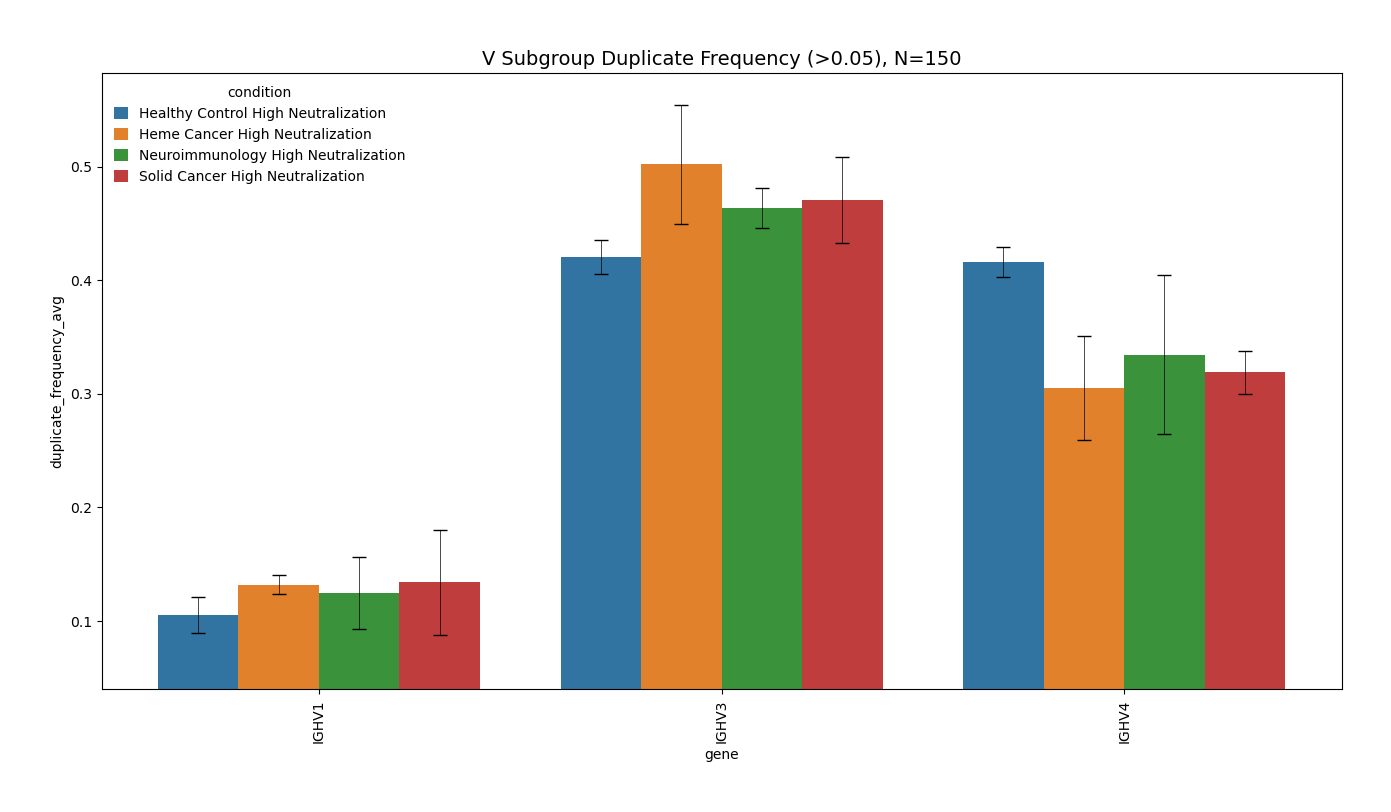

In [7]:
# add std.dev error bar 
# std.err of mean = std.dev/sqrt(N)

threshold = 0.05
ylim_mult = 0.8

df = br.load_gene_usage_group_data(
    repcalc_dir=repcalc_dir,
    groups=diag_hi_groups,
    processing_stage='igblast.makedb.gene.clone',
    call_type='v_call',
    level='subgroup'
)

# V Duplicate Frequency
fig, ax = gr.plot_duplicate_frequency(
    df=df,
    hue_order=None,
    palette=v_subgroup_cmap,
    threshold=threshold,
    title=f'V Subgroup Duplicate Frequency (>0.05), N={sum([e[2] for e in diag_hi_groups])}',
    ylim=(threshold*ylim_mult, None),
    split=True,
    errorbar='se'
)

fig.show()

## V Gene

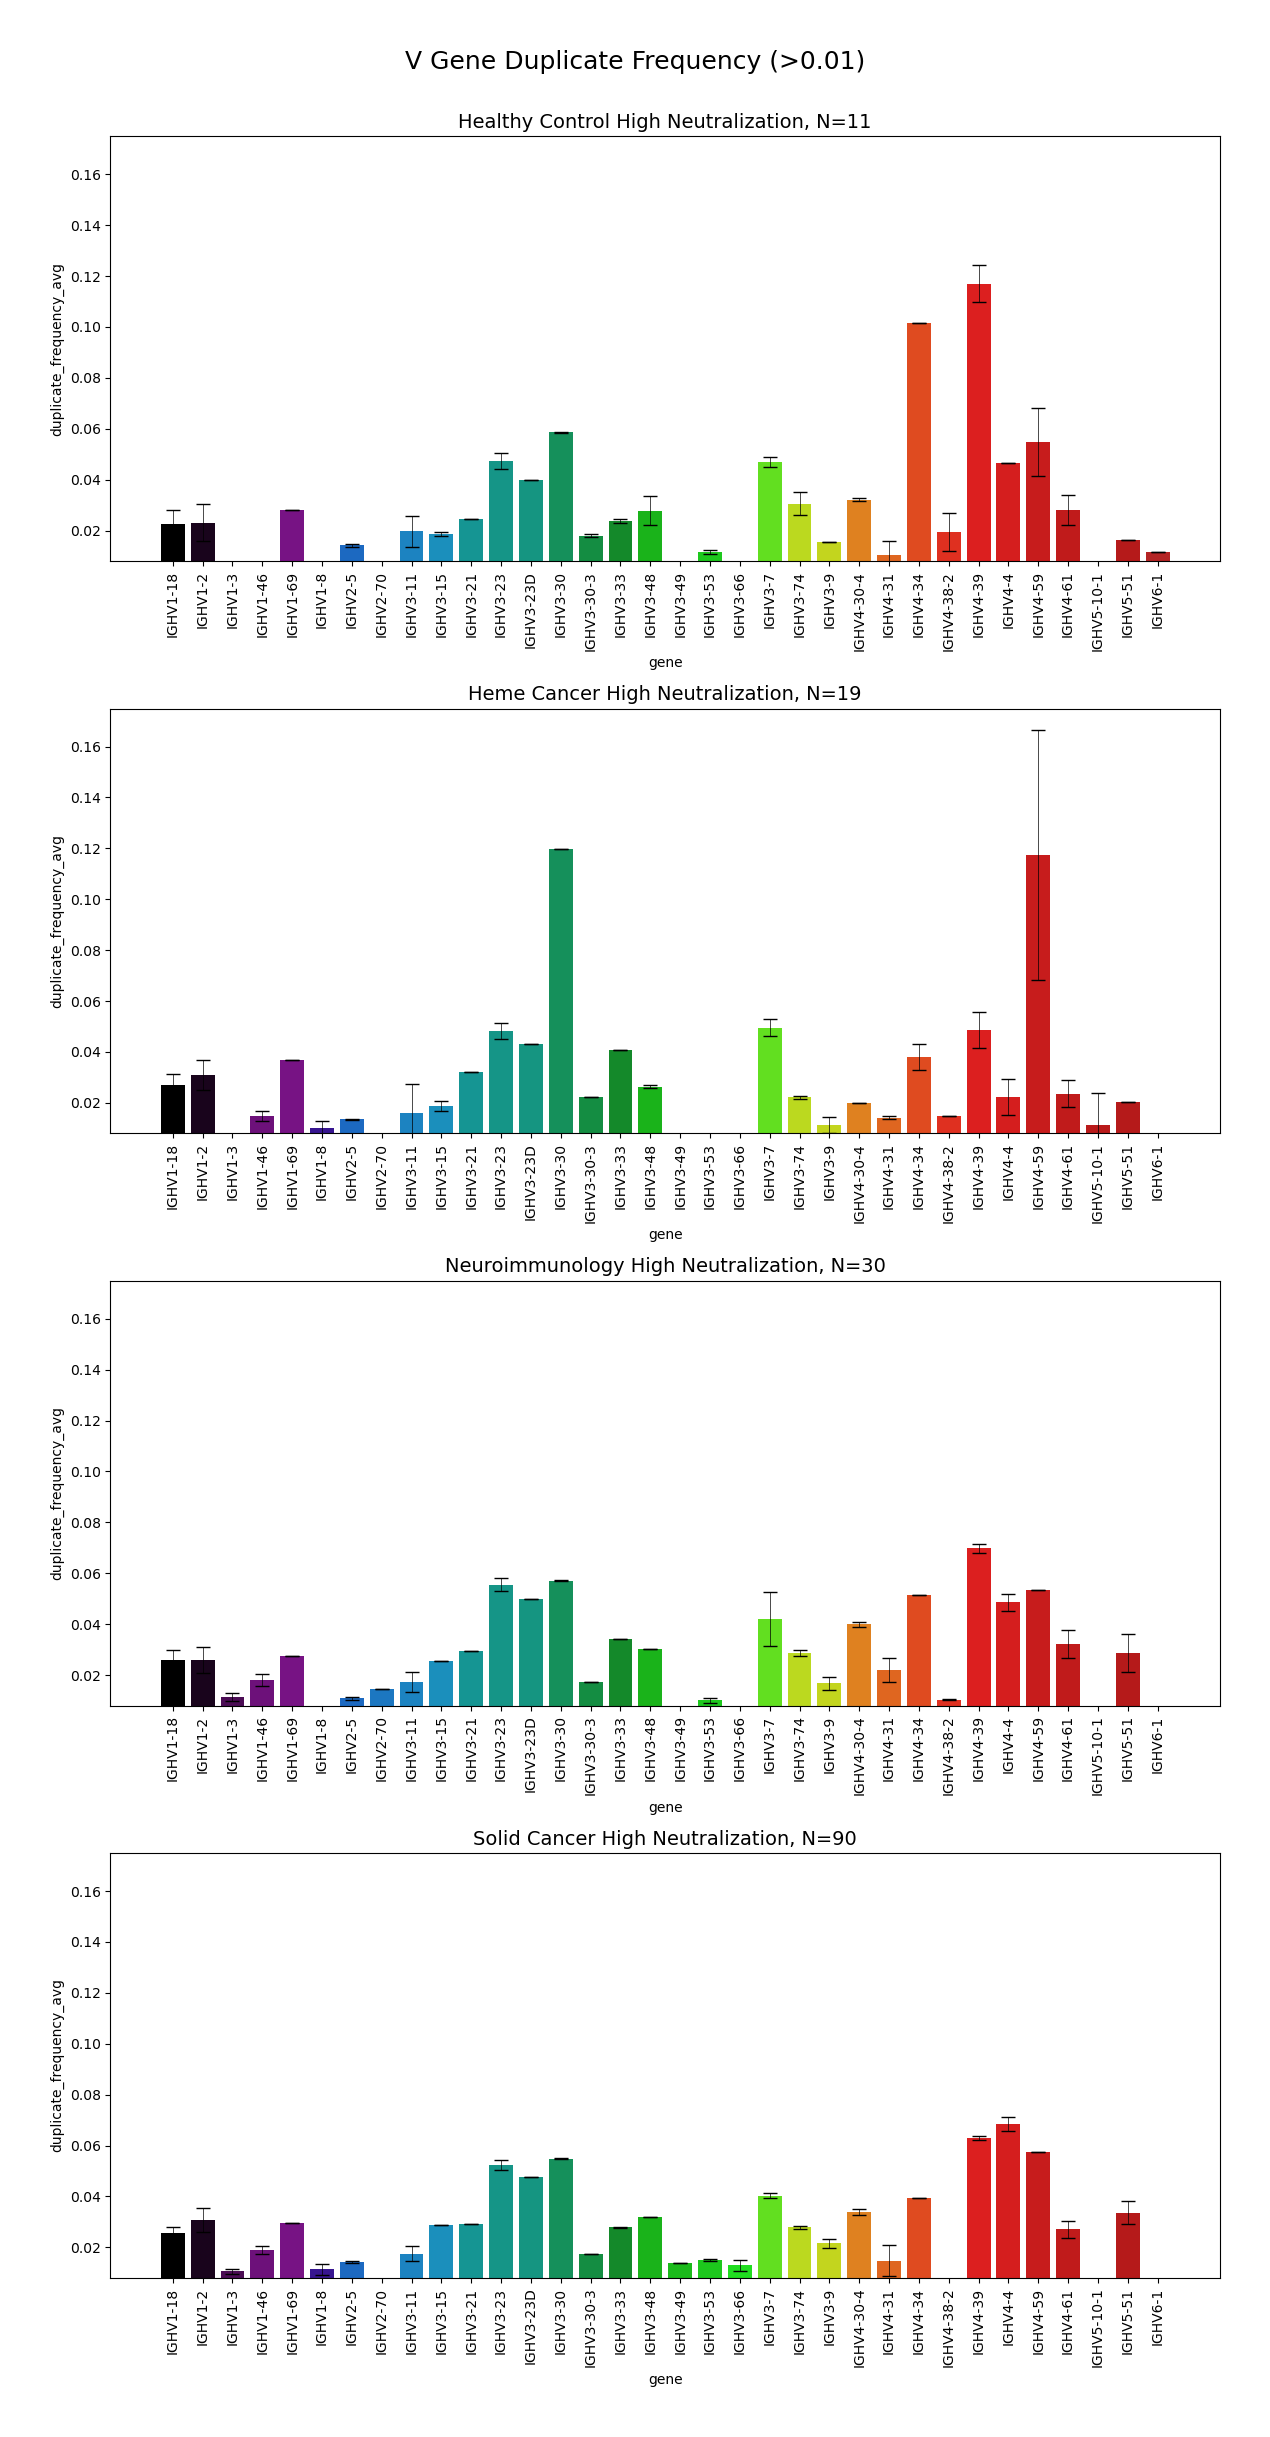

In [8]:
# add in number of samples on title
# add in number of unique to go next or on top
    # num_of_unique_seq/total_num_of_duplicate_seq

threshold = 0.01
ylim_mult = 0.8

df = br.load_gene_usage_group_data(
    repcalc_dir=repcalc_dir,
    groups=diag_hi_groups,
    processing_stage='igblast.makedb.gene.clone',
    call_type='v_call',
    level='gene'
)

genes = df[df['duplicate_frequency_avg']>=threshold]['gene'].unique()

def plot1(ax):
    group_name = diag_hi_groups[0][1]
    gr.plot_duplicate_frequency(
        df=df[df['condition']==group_name].copy(),
        hue_order=None,
        palette=v_genes_cmap,
        threshold=threshold,
        title=f'{group_name}, N={diag_hi_groups[0][2]}',
        ylim=(ylim_mult*threshold, None),
        ax=ax,
        categories=genes,
        split=False,
        errorbar='se'
    )

def plot2(ax):
    group_name = diag_hi_groups[1][1]
    gr.plot_duplicate_frequency(
        df=df[df['condition']==group_name].copy(),
        hue_order=None,
        palette=v_genes_cmap,
        threshold=threshold,
        title=f'{group_name}, N={diag_hi_groups[1][2]}',
        ylim=(ylim_mult*threshold, None),
        ax=ax,
        categories=genes,
        split=False,
        errorbar='se'
    )
def plot3(ax):
    group_name = diag_hi_groups[2][1]
    gr.plot_duplicate_frequency(
        df=df[df['condition']==group_name].copy(),
        hue_order=None,
        palette=v_genes_cmap,
        threshold=threshold,
        title=f'{group_name}, N={diag_hi_groups[2][2]}',
        ylim=(ylim_mult*threshold, None),
        ax=ax,
        categories=genes,
        split=False,
        errorbar='se'
    )
def plot4(ax):
    group_name = diag_hi_groups[3][1]
    ax = gr.plot_duplicate_frequency(
        df=df[df['condition']==group_name].copy(),
        hue_order=None,
        palette=v_genes_cmap,
        threshold=threshold,
        title=f'{group_name}, N={diag_hi_groups[3][2]}',
        ylim=(ylim_mult*threshold, None),
        ax=ax,
        categories=genes,
        split=False,
        errorbar='se'
    )

fig, axes = plot_four_vertical_layout(plot1, plot2, plot3, plot4, figsize=(12,24), sharey=True)
fig.suptitle(f'V Gene Duplicate Frequency (>{threshold})', fontsize=18)
fig.show()

## V subgroup/V gene plot
new plot where each gene within a subgroup is shown

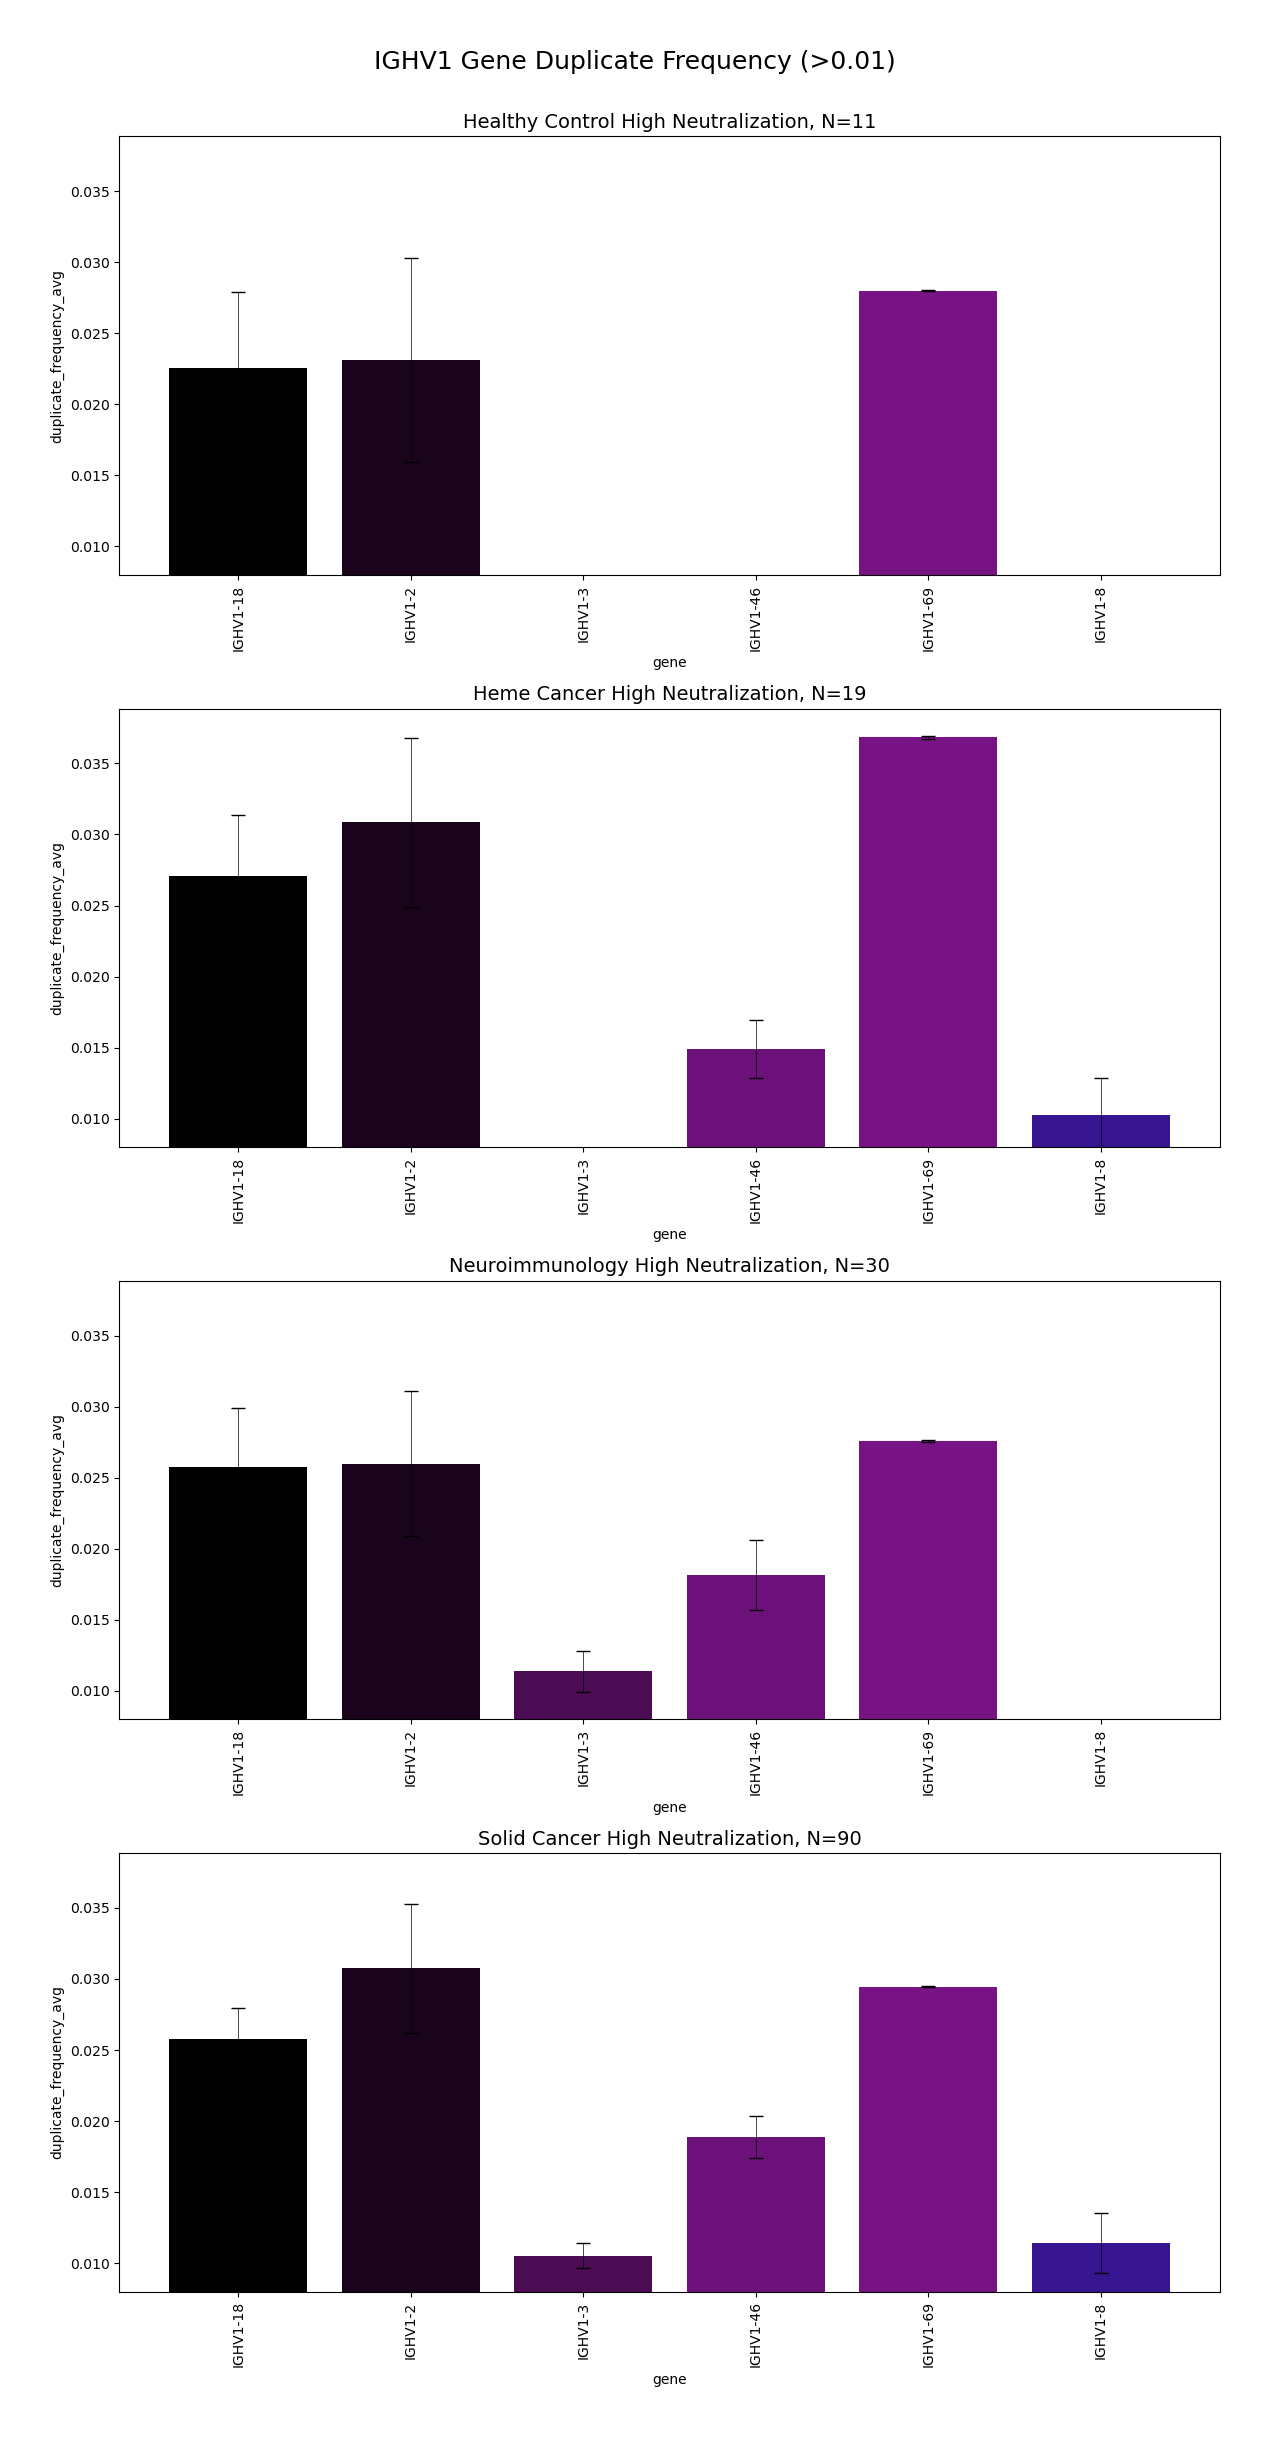

In [9]:
# add in number of samples on title
# add in number of unique to go next or on top
    # num_of_unique_seq/total_num_of_duplicate_seq

threshold = 0.01
ylim_mult = 0.8

# df = df[df['gene'].str.split('IG').str[1].str[0]=='H']
for e in ['1', '3', '4']:
    df = br.load_gene_usage_group_data(
        repcalc_dir=repcalc_dir,
        groups=diag_hi_groups,
        processing_stage='igblast.makedb.gene.clone',
        call_type='v_call',
        level='gene'
    )

    df = df[df['gene'].str.split('').str[5]==e]
    genes = df[df['duplicate_frequency_avg']>=threshold]['gene'].unique()

    # add in number of samples on title
    # add in number of unique to go next or on top
        # num_of_unique_seq/total_num_of_duplicate_seq

    def plot1(ax):
        group_name = diag_hi_groups[0][1]
        gr.plot_duplicate_frequency(
            df=df[df['condition']==group_name].copy(),
            hue_order=None,
            palette=v_genes_cmap,
            threshold=threshold,
            title=f'{group_name}, N={diag_hi_groups[0][2]}',
            ylim=(ylim_mult*threshold, None),
            ax=ax,
            categories=genes,
            split=False,
            errorbar='se'
        )

    def plot2(ax):
        group_name = diag_hi_groups[1][1]
        gr.plot_duplicate_frequency(
            df=df[df['condition']==group_name].copy(),
            hue_order=None,
            palette=v_genes_cmap,
            threshold=threshold,
            title=f'{group_name}, N={diag_hi_groups[1][2]}',
            ylim=(ylim_mult*threshold, None),
            ax=ax,
            categories=genes,
            split=False,
            errorbar='se'
        )
    def plot3(ax):
        group_name = diag_hi_groups[2][1]
        gr.plot_duplicate_frequency(
            df=df[df['condition']==group_name].copy(),
            hue_order=None,
            palette=v_genes_cmap,
            threshold=threshold,
            title=f'{group_name}, N={diag_hi_groups[2][2]}',
            ylim=(ylim_mult*threshold, None),
            ax=ax,
            categories=genes,
            split=False,
            errorbar='se'
        )
    def plot4(ax):
        group_name = diag_hi_groups[3][1]
        ax = gr.plot_duplicate_frequency(
            df=df[df['condition']==group_name].copy(),
            hue_order=None,
            palette=v_genes_cmap,
            threshold=threshold,
            title=f'{group_name}, N={diag_hi_groups[3][2]}',
            ylim=(ylim_mult*threshold, None),
            ax=ax,
            categories=genes,
            split=False,
            errorbar='se'
        )

    fig, axes = plot_four_vertical_layout(plot1, plot2, plot3, plot4, figsize=(12,24), sharey=True)
    fig.suptitle(f'IGHV{e} Gene Duplicate Frequency (>{threshold})', fontsize=18)
    fig.show()
    break

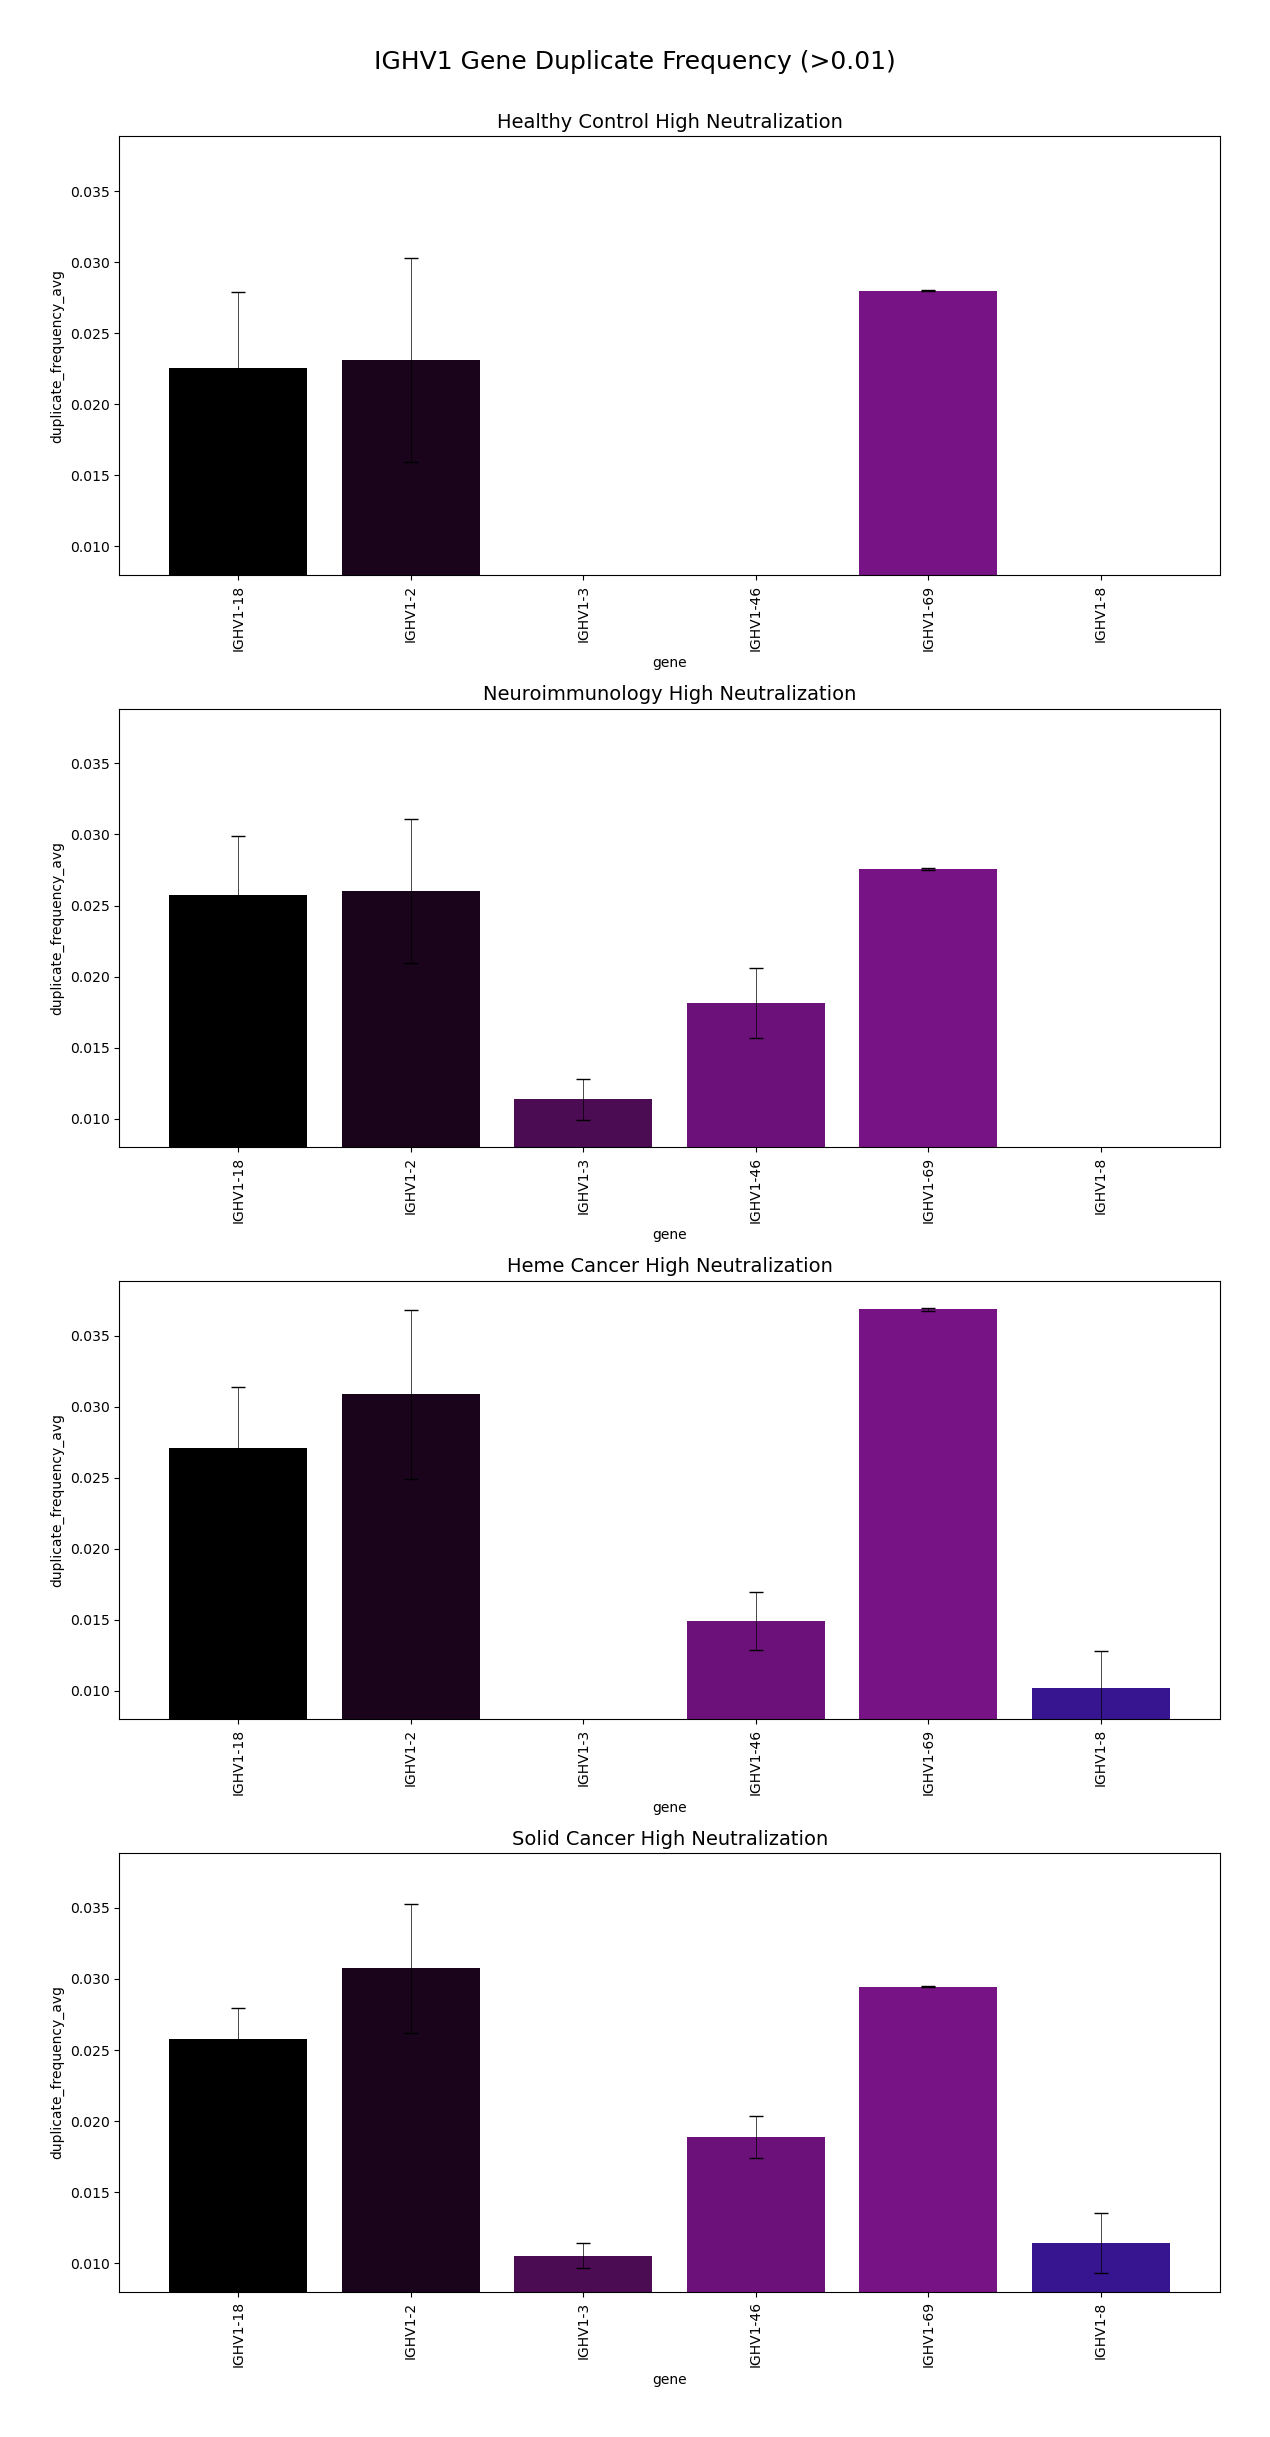

In [25]:
# add in number of samples on title
# add in number of unique to go next or on top
    # num_of_unique_seq/total_num_of_duplicate_seq

threshold = 0.01
ylim_mult = 0.8

# df = df[df['gene'].str.split('IG').str[1].str[0]=='H']
for e in ['1', '3', '4']:
    df = br.load_gene_usage_group_data(
        repcalc_dir=repcalc_dir,
        groups=diag_hi_groups,
        processing_stage='igblast.makedb.gene.clone',
        call_type='v_call',
        level='gene'
    )

    df = df[df['gene'].str.split('').str[5]==e]
    genes = df[df['duplicate_frequency_avg']>=threshold]['gene'].unique()

    def plot1(ax):
        group_name = 'Healthy Control High Neutralization'
        gr.plot_duplicate_frequency(
            df=df[df['condition']==group_name].copy(),
            hue_order=None,
            palette=v_genes_cmap,
            threshold=threshold,
            title=f'{group_name}',
            ylim=(ylim_mult*threshold, None),
            ax=ax,
            categories=genes,
            split=False,
            errorbar='se'
        )

    def plot2(ax):
        group_name = 'Neuroimmunology High Neutralization'
        gr.plot_duplicate_frequency(
            df=df[df['condition']==group_name].copy(),
            hue_order=None,
            palette=v_genes_cmap,
            threshold=threshold,
            title=f'{group_name}',
            ylim=(ylim_mult*threshold, None),
            ax=ax,
            categories=genes,
            split=False,
            errorbar='se'
        )
    def plot3(ax):
        group_name = 'Heme Cancer High Neutralization'
        gr.plot_duplicate_frequency(
            df=df[df['condition']==group_name].copy(),
            hue_order=None,
            palette=v_genes_cmap,
            threshold=threshold,
            title=f'{group_name}',
            ylim=(ylim_mult*threshold, None),
            ax=ax,
            categories=genes,
            split=False,
            errorbar='se'
        )
    def plot4(ax):
        group_name = 'Solid Cancer High Neutralization'
        ax = gr.plot_duplicate_frequency(
            df=df[df['condition']==group_name].copy(),
            hue_order=None,
            palette=v_genes_cmap,
            threshold=threshold,
            title=f'{group_name}',
            ylim=(ylim_mult*threshold, None),
            ax=ax,
            categories=genes,
            split=False,
            errorbar='se'
        )

    fig, ax = plot_four_vertical_layout(plot1, plot2, plot3, plot4, figsize=(12,24), sharey=True)
    fig.suptitle(f'IGHV{e} Gene Duplicate Frequency (>{threshold})', fontsize=18)
    fig.show()
    break

## CDR3

### Junction

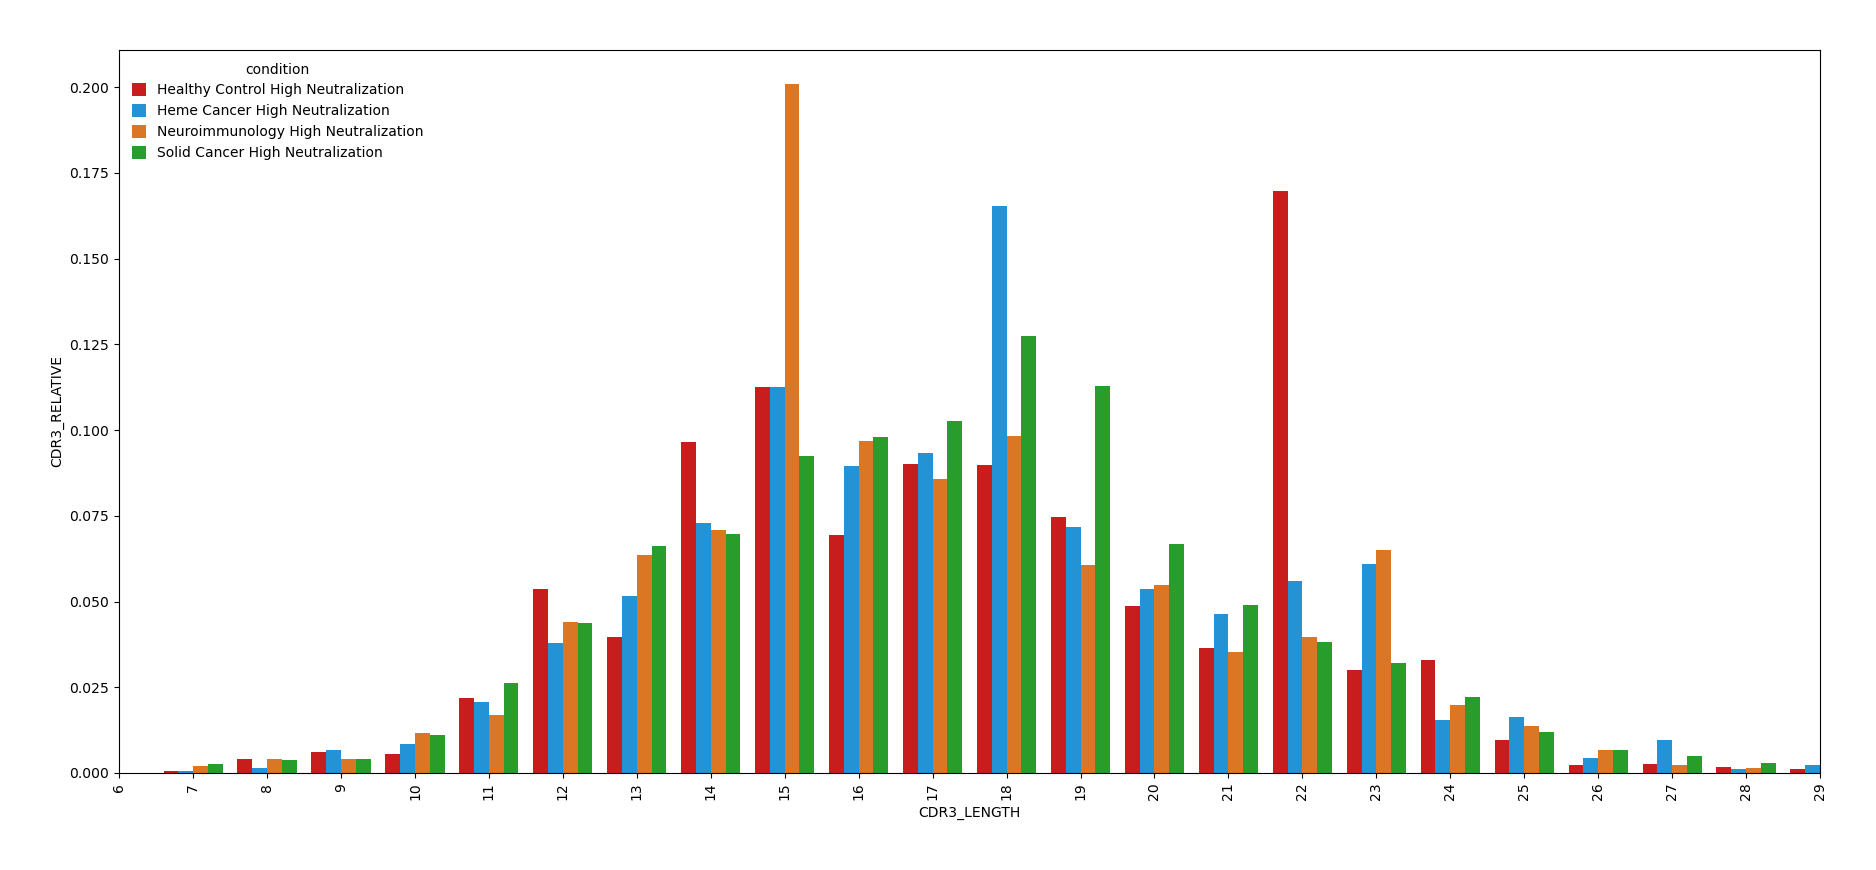

In [38]:
df = br.load_and_prepare_data_junction_aa(
    repcalc_dir=repcalc_dir,
    groups=diag_hi_groups,
    processing_stage='.igblast.makedb.allele.clone.group.',
    call_type='junction_aa_length'
)

fig, ax = gr.plot_junction_aa_length(
    df=df,
    x_col='CDR3_LENGTH',
    y_col='CDR3_RELATIVE',
    hue_col='condition',
    palette=['xkcd:red', 'xkcd:azure', 'xkcd:orange', 'xkcd:green']
)

fig.show()

## Clonal Abundance

In [10]:
processing_stage = 'igblast.makedb.allele.clone'
clone_tool = 'repcalc' # repcalc, changeo
df = br.load_and_prepare_clonal_abundance_group_data(repcalc_dir, diag_hi_groups, all_groups=repertoire_groups, clone_tool=clone_tool, processing_stage=processing_stage)
df.head()

repertoire_id  clone_id  seq_count  copy_count  \
0  df61993a-02fe-40c6-ab59-c9749275348b       321        117         187   
1  df61993a-02fe-40c6-ab59-c9749275348b       677         73         139   
2  df61993a-02fe-40c6-ab59-c9749275348b       153         55          94   
3  df61993a-02fe-40c6-ab59-c9749275348b       460         38          84   
4  df61993a-02fe-40c6-ab59-c9749275348b       426         38          78   

   seq_freq  abundance  rank  cumulative_abundance  \
0  0.027420   0.026334     1              0.026334   
1  0.017108   0.019575     2              0.045909   
2  0.012890   0.013238     3              0.059147   
3  0.008906   0.011829     4              0.070976   
4  0.008906   0.010984     5              0.081960   

                             condition  
0  Healthy Control High Neutralization  
1  Healthy Control High Neutralization  
2  Healthy Control High Neutralization  
3  Healthy Control High Neutralization  
4  Healthy Control High Neutralization

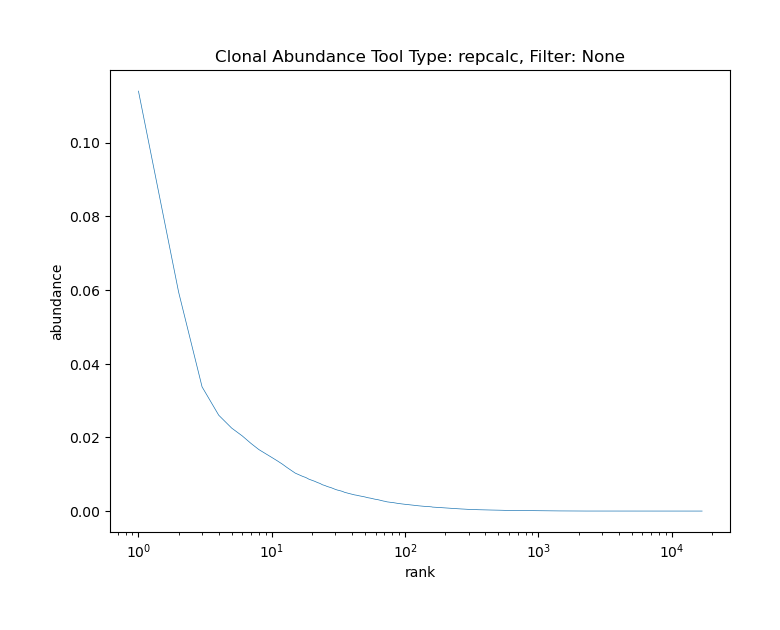

In [11]:
fig, ax = gr.plot_clonal_abundance(
    df,
    y_col = 'abundance',
    figsize=(8, 6),
    plot_title = f'Clonal Abundance Tool Type: {clone_tool}, Filter: None',
    legend_title = None,
    hue=None
)
fig.show()

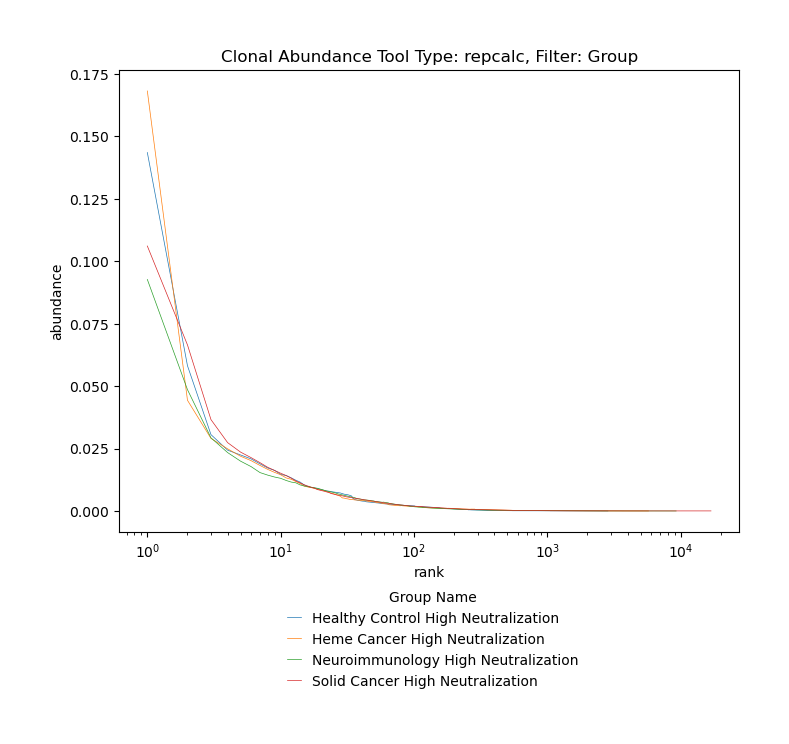

In [12]:
fig, ax = gr.plot_clonal_abundance(
    df,
    y_col = 'abundance',
    figsize=(8, 6),
    plot_title = f'Clonal Abundance Tool Type: {clone_tool}, Filter: Group',
    legend_title = 'Group Name',
    hue='condition'
)
fig.show()

/tmp/ipykernel_3100573/1653643407.py:283: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle


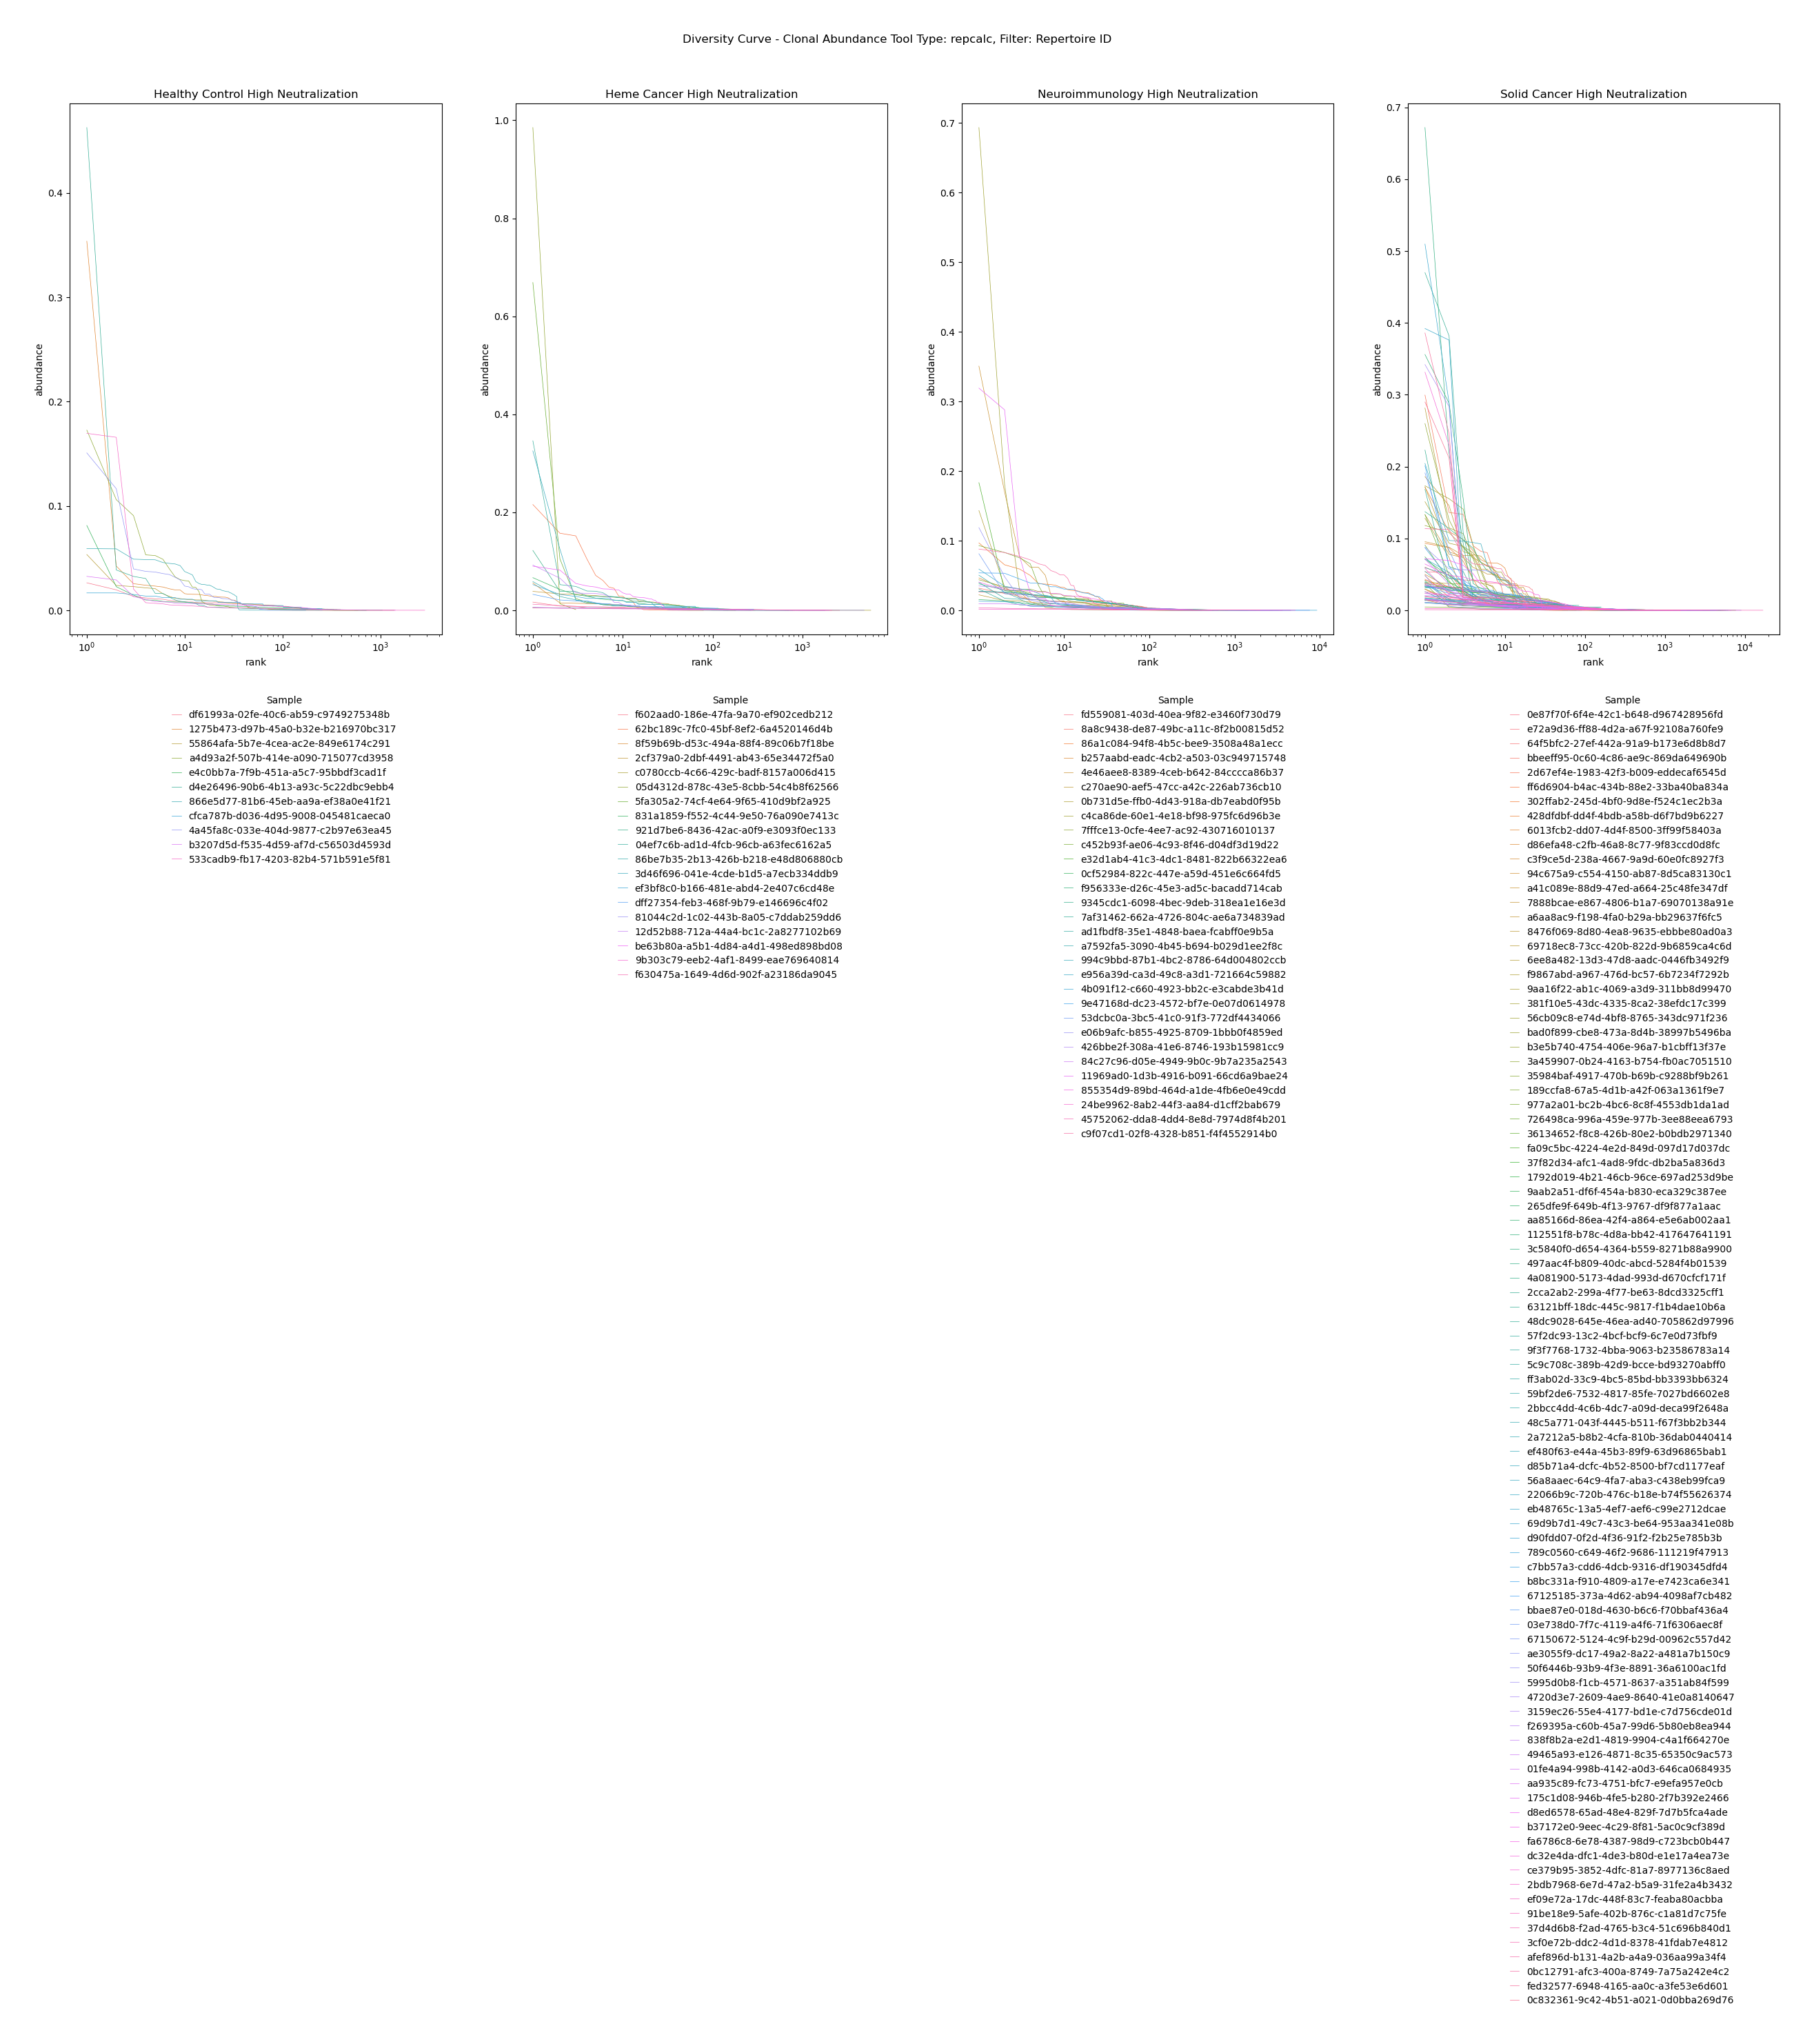

In [13]:
processing_stage = 'igblast.makedb.allele.clone'
clone_tool = 'repcalc' # repcalc, changeo
df = br.load_and_prepare_clonal_abundance_group_data(repcalc_dir, diag_hi_groups, all_groups=repertoire_groups, clone_tool=clone_tool, processing_stage=processing_stage)

def plot1(ax):
    gr.plot_clonal_abundance(
        df[df['condition']==diag_hi_groups[0][1]],
        y_col = 'abundance',
        figsize=(8, 10),
        plot_title = f'{diag_hi_groups[0][1]}',
        legend_title = 'Sample',
        hue='repertoire_id',
        ax=ax
    )

def plot2(ax):
    gr.plot_clonal_abundance(
        df[df['condition']==diag_hi_groups[1][1]],
        y_col = 'abundance',
        figsize=(8, 10),
        plot_title = f'{diag_hi_groups[1][1]}',
        legend_title = 'Sample',
        hue='repertoire_id',
        ax=ax
    )

def plot3(ax):
    gr.plot_clonal_abundance(
        df[df['condition']==diag_hi_groups[2][1]],
        y_col = 'abundance',
        figsize=(8, 10),
        plot_title = f'{diag_hi_groups[2][1]}',
        legend_title = 'Sample',
        hue='repertoire_id',
        ax=ax
    )

def plot4(ax):
    gr.plot_clonal_abundance(
        df[df['condition']==diag_hi_groups[3][1]],
        y_col = 'abundance',
        figsize=(8, 10),
        plot_title = f'{diag_hi_groups[3][1]}',
        legend_title = 'Sample',
        hue='repertoire_id',
        ax=ax
    )

fig, axes = plot_four_horizontal_layout(plot1, plot2, plot3, plot4, figsize=(32,10))
fig.suptitle(f'Diversity Curve - Clonal Abundance Tool Type: {clone_tool}, Filter: Repertoire ID')
fig.show()

/tmp/ipykernel_3100573/1653643407.py:283: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle


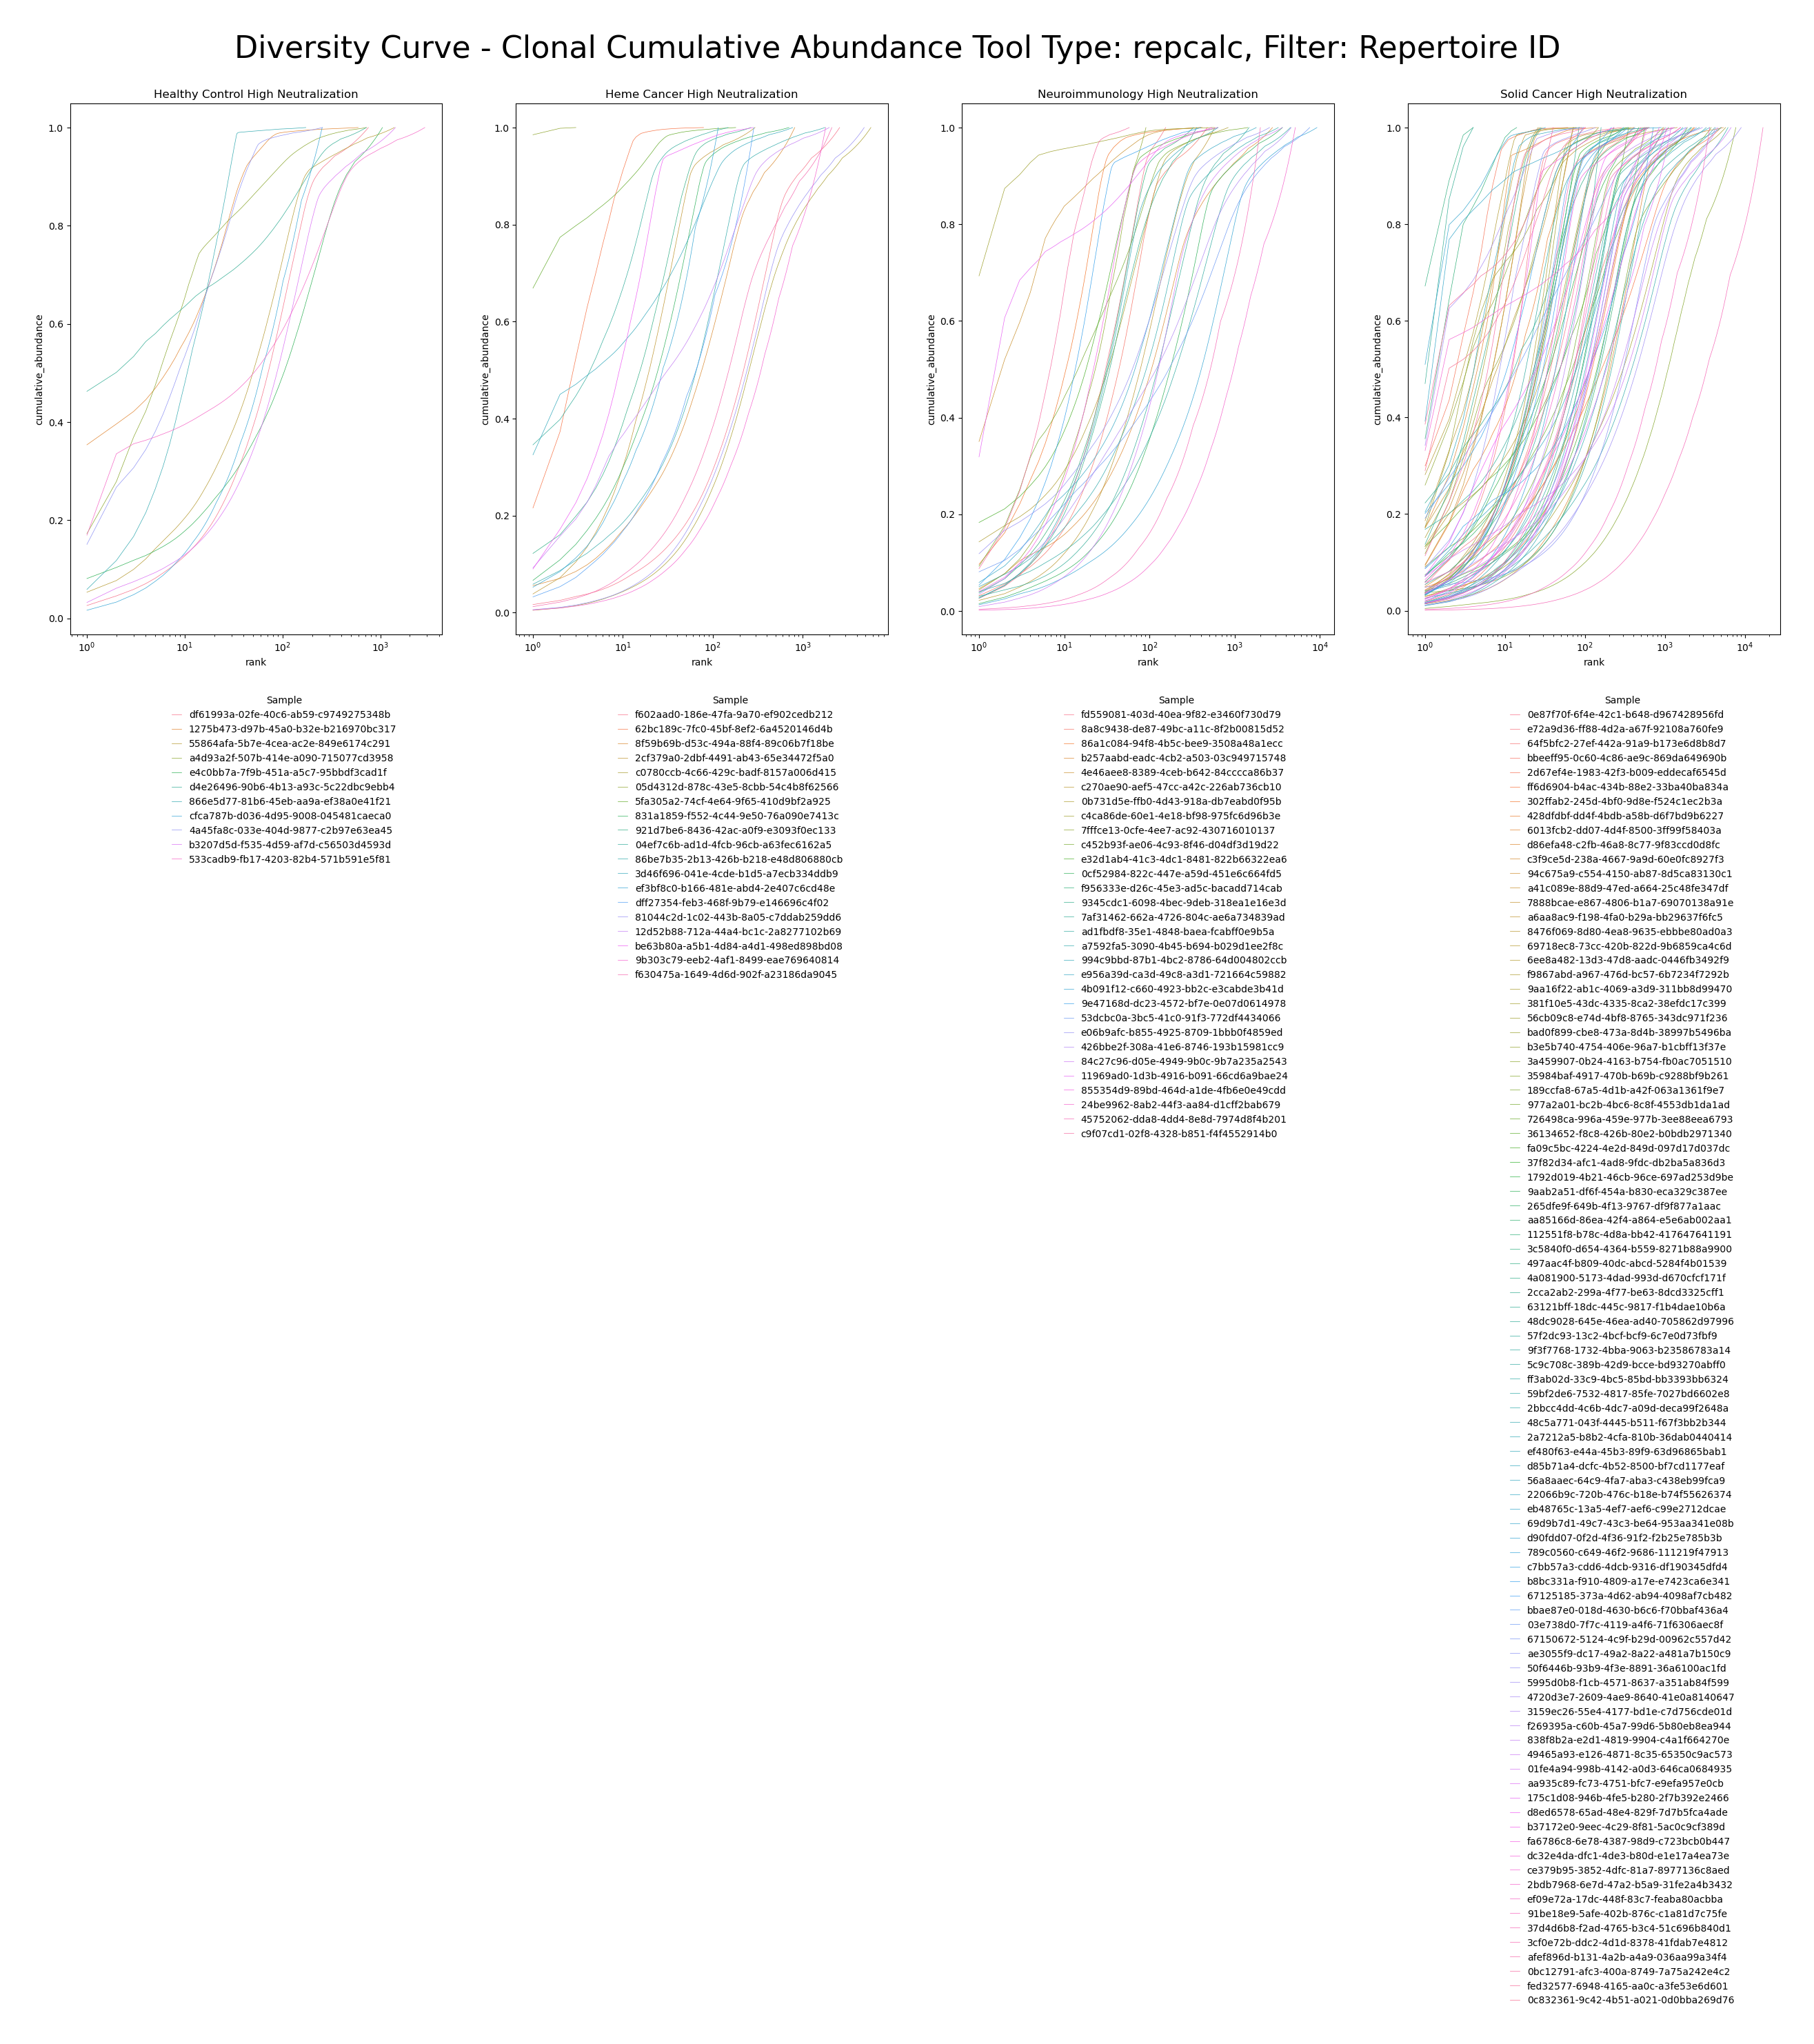

In [15]:
processing_stage = 'igblast.makedb.allele.clone'
clone_tool = 'repcalc' # repcalc, changeo
df = br.load_and_prepare_clonal_abundance_group_data(repcalc_dir, diag_hi_groups, all_groups=repertoire_groups, clone_tool=clone_tool, processing_stage=processing_stage)

def plot1(ax):
    gr.plot_clonal_abundance(
        df[df['condition']==diag_hi_groups[0][1]],
        y_col = 'cumulative_abundance',
        figsize=(8, 10),
        plot_title = f'{diag_hi_groups[0][1]}',
        legend_title = 'Sample',
        hue='repertoire_id',
        ax=ax
    )

def plot2(ax):
    gr.plot_clonal_abundance(
        df[df['condition']==diag_hi_groups[1][1]],
        y_col = 'cumulative_abundance',
        figsize=(8, 10),
        plot_title = f'{diag_hi_groups[1][1]}',
        legend_title = 'Sample',
        hue='repertoire_id',
        ax=ax
    )

def plot3(ax):
    gr.plot_clonal_abundance(
        df[df['condition']==diag_hi_groups[2][1]],
        y_col = 'cumulative_abundance',
        figsize=(8, 10),
        plot_title = f'{diag_hi_groups[2][1]}',
        legend_title = 'Sample',
        hue='repertoire_id',
        ax=ax
    )

def plot4(ax):
    gr.plot_clonal_abundance(
        df[df['condition']==diag_hi_groups[3][1]],
        y_col = 'cumulative_abundance',
        figsize=(8, 10),
        plot_title = f'{diag_hi_groups[3][1]}',
        legend_title = 'Sample',
        hue='repertoire_id',
        ax=ax
    )

fig, axes = plot_four_horizontal_layout(plot1, plot2, plot3, plot4, figsize=(32,10))
fig.suptitle(f'Diversity Curve - Clonal Cumulative Abundance Tool Type: {clone_tool}, Filter: Repertoire ID', fontsize=32)
fig.show()

/tmp/ipykernel_3100573/1653643407.py:283: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle


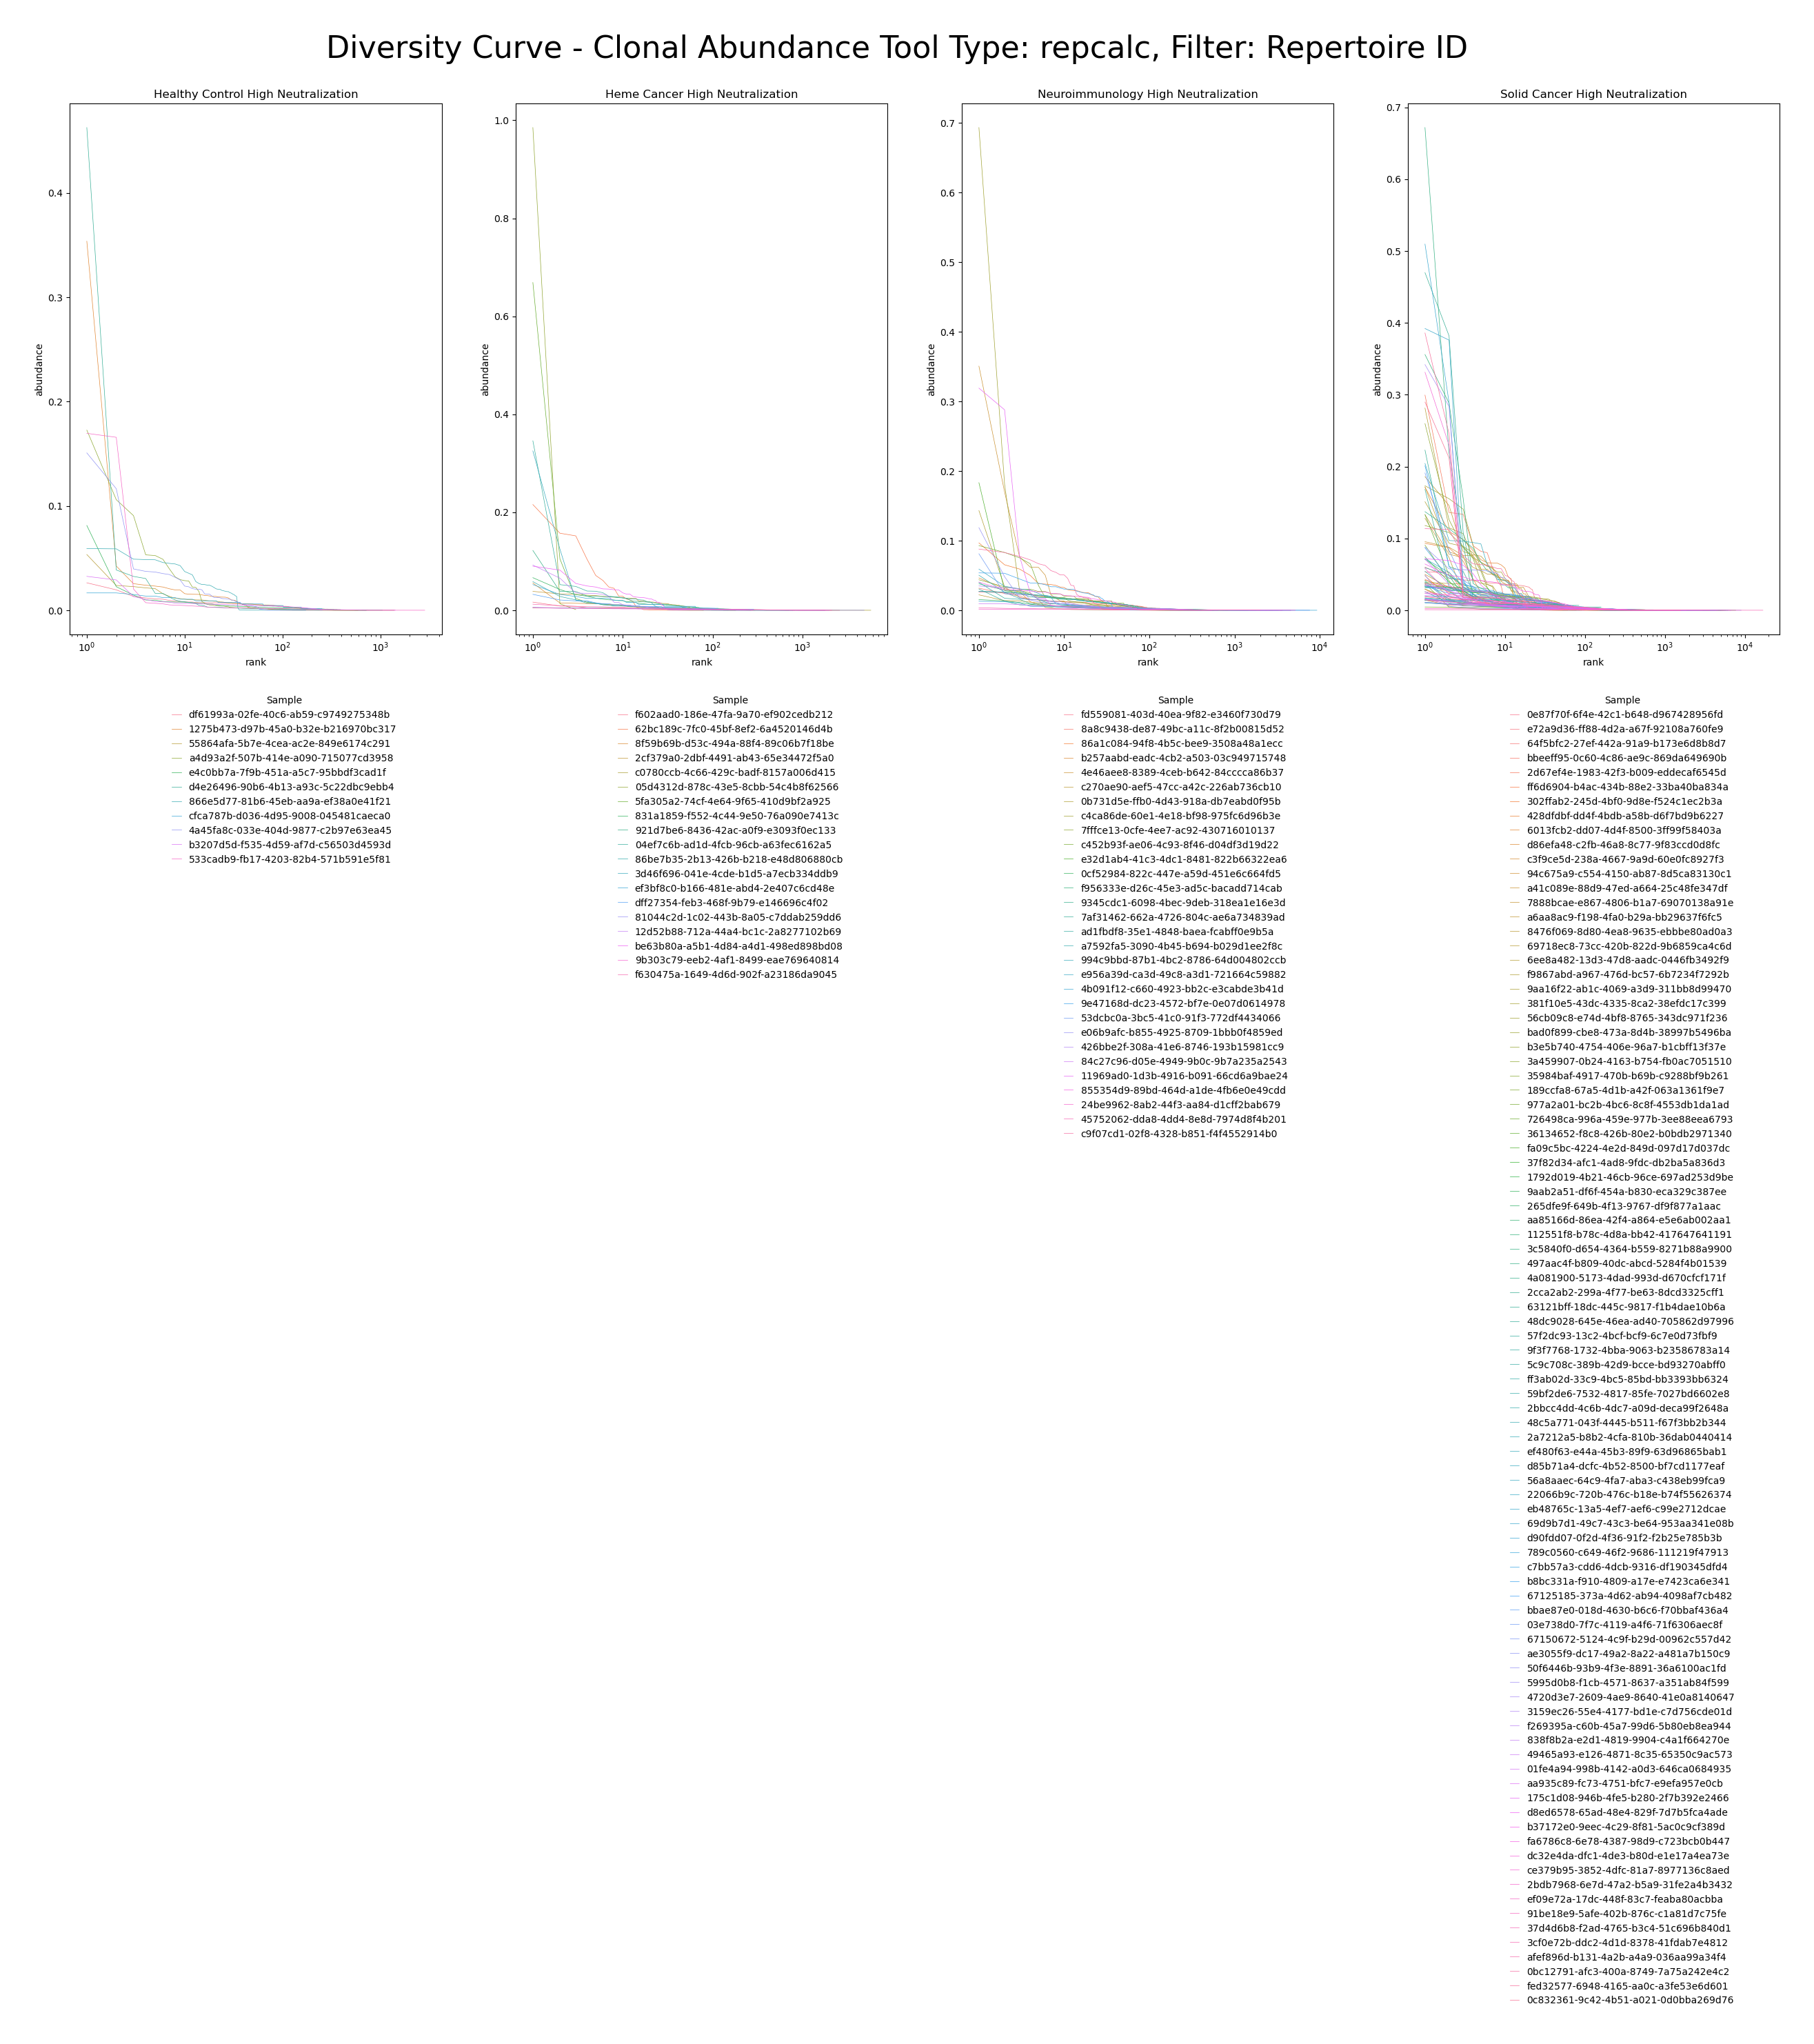

In [16]:
processing_stage = 'igblast.makedb.allele.clone'
clone_tool = 'repcalc' # repcalc, changeo
df = br.load_and_prepare_clonal_abundance_group_data(repcalc_dir, diag_hi_groups, all_groups=repertoire_groups, clone_tool=clone_tool, processing_stage=processing_stage)

def plot1(ax):
    gr.plot_clonal_abundance(
        df[df['condition']==diag_hi_groups[0][1]],
        y_col = 'abundance',
        figsize=(8, 10),
        plot_title = f'{diag_hi_groups[0][1]}',
        legend_title = 'Sample',
        hue='repertoire_id',
        ax=ax
    )

def plot2(ax):
    gr.plot_clonal_abundance(
        df[df['condition']==diag_hi_groups[1][1]],
        y_col = 'abundance',
        figsize=(8, 10),
        plot_title = f'{diag_hi_groups[1][1]}',
        legend_title = 'Sample',
        hue='repertoire_id',
        ax=ax
    )

def plot3(ax):
    gr.plot_clonal_abundance(
        df[df['condition']==diag_hi_groups[2][1]],
        y_col = 'abundance',
        figsize=(8, 10),
        plot_title = f'{diag_hi_groups[2][1]}',
        legend_title = 'Sample',
        hue='repertoire_id',
        ax=ax
    )

def plot4(ax):
    gr.plot_clonal_abundance(
        df[df['condition']==diag_hi_groups[3][1]],
        y_col = 'abundance',
        figsize=(8, 10),
        plot_title = f'{diag_hi_groups[3][1]}',
        legend_title = 'Sample',
        hue='repertoire_id',
        ax=ax
    )

fig, axes = plot_four_horizontal_layout(plot1, plot2, plot3, plot4, figsize=(32,10))
fig.suptitle(f'Diversity Curve - Clonal Abundance Tool Type: {clone_tool}, Filter: Repertoire ID', fontsize=32)
fig.show()

## Diversity Curves

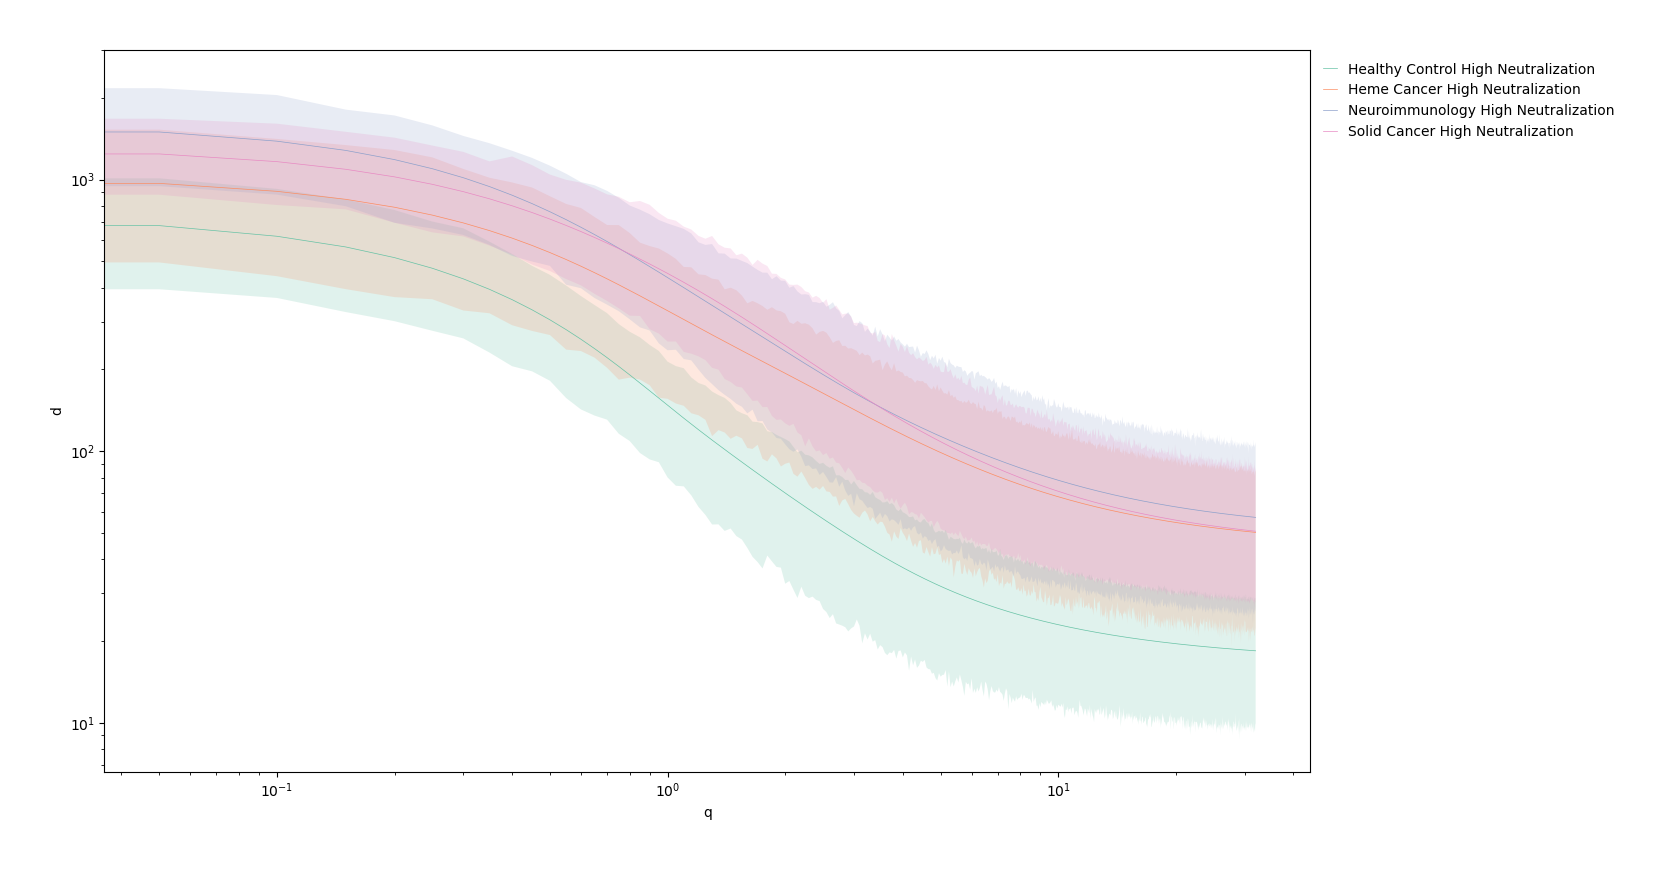

In [17]:
dfs = []
for i, (group_id, group_name, *_) in enumerate(diag_hi_groups):
        
    df = br.load_diversity_group_data(
        data_dir=repcalc_dir,
        repertoire_group=repertoire_groups[group_id],
        processing_stage='igblast.makedb.gene.clone'
    )
    dfs.append(df)
df = pd.concat(dfs)

fig, ax = gr.plot_diversity_curve(
    df=df
)

calculate single number for each patient and create box and whisker. Number = normalized shannon entropy by pulling two values from curve. value at q=1/q=0 (double check)

In [12]:
repertoire_groups

{'b08f9f20-8770-42e2-a785-ff9443b6edb6': {'repertoire_group_id': 'b08f9f20-8770-42e2-a785-ff9443b6edb6',
  'repertoire_group_name': 'High Neutralization',
  'repertoire_group_description': None,
  'repertoires': [{'repertoire_id': 'f602aad0-186e-47fa-9a70-ef902cedb212'},
   {'repertoire_id': '62bc189c-7fc0-45bf-8ef2-6a4520146d4b'},
   {'repertoire_id': '8f59b69b-d53c-494a-88f4-89c06b7f18be'},
   {'repertoire_id': '0e87f70f-6f4e-42c1-b648-d967428956fd'},
   {'repertoire_id': 'e72a9d36-ff88-4d2a-a67f-92108a760fe9'},
   {'repertoire_id': '64f5bfc2-27ef-442a-91a9-b173e6d8b8d7'},
   {'repertoire_id': 'bbeeff95-0c60-4c86-ae9c-869da649690b'},
   {'repertoire_id': 'fd559081-403d-40ea-9f82-e3460f730d79'},
   {'repertoire_id': '2d67ef4e-1983-42f3-b009-eddecaf6545d'},
   {'repertoire_id': 'ff6d6904-b4ac-434b-88e2-33ba40ba834a'},
   {'repertoire_id': '302ffab2-245d-4bf0-9d8e-f524c1ec2b3a'},
   {'repertoire_id': '2cf379a0-2dbf-4491-ab43-65e34472f5a0'},
   {'repertoire_id': 'c0780ccb-4c66-429c-badf-

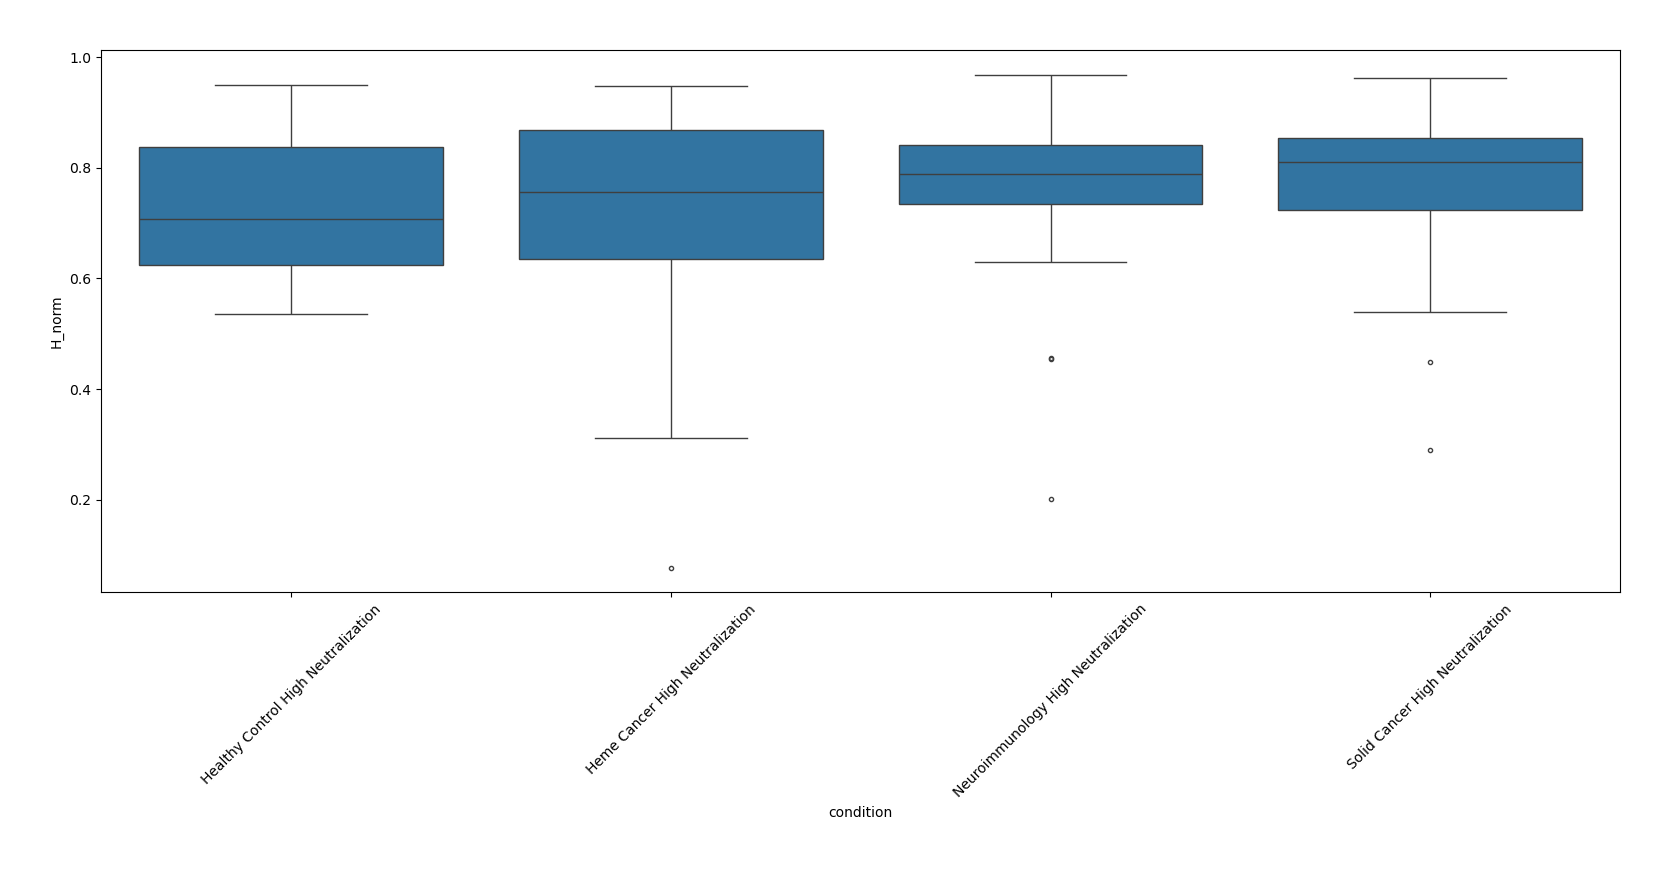

In [7]:
df = br.load_diversity_multiple_group_data(
    data_dir=repcalc_dir,
    repertoire_groups=diag_hi_groups,
    processing_stage='igblast.makedb.gene.clone',
    all_groups=repertoire_groups
)

fig, ax = gr.plot_diversity_boxplot(
    df=df,
    hue='condition',
    legend=False
)

fig.show()

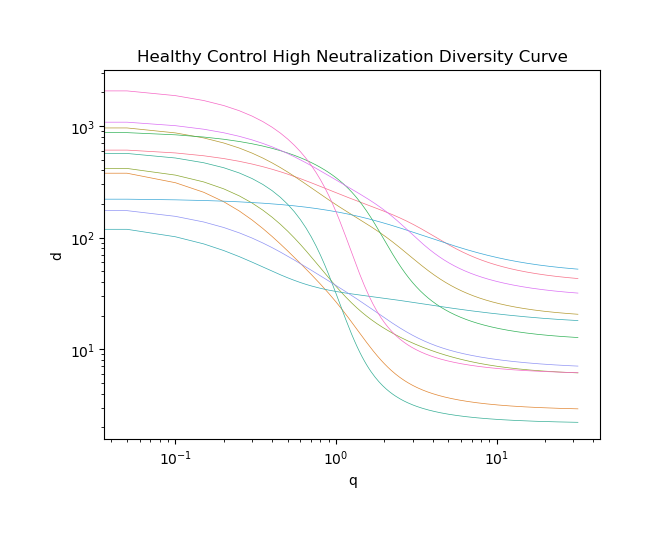

In [ ]:
dfs = []
for i, (group_id, group_name, *_) in enumerate(diag_hi_groups):
        
    df = br.load_diversity_group_data(
        data_dir=repcalc_dir,
        repertoire_group=repertoire_groups[group_id],
        processing_stage='igblast.makedb.gene.clone'
    )
    dfs.append(df)
df = pd.concat(dfs)

group_name = 'Healthy Control High Neutralization'
fig, ax = plt.subplots()
sns.lineplot(data=df[df['condition']==group_name].copy(),
                 x='q',
                 y='d',
                 markers=True,
                 ax=ax,
                 hue='repertoire_id',
                 legend=False)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(f'{group_name} Diversity Curve')
fig.show()

(np.float64(6.98588737370937), np.float64(1384.5200761175372))
(np.float64(19.10683943040324), np.float64(3004.2658684720745))
(np.float64(15.37791573699999), np.float64(2108.027239911424))
(np.float64(22.22816548756835), np.float64(2200.334920857173))


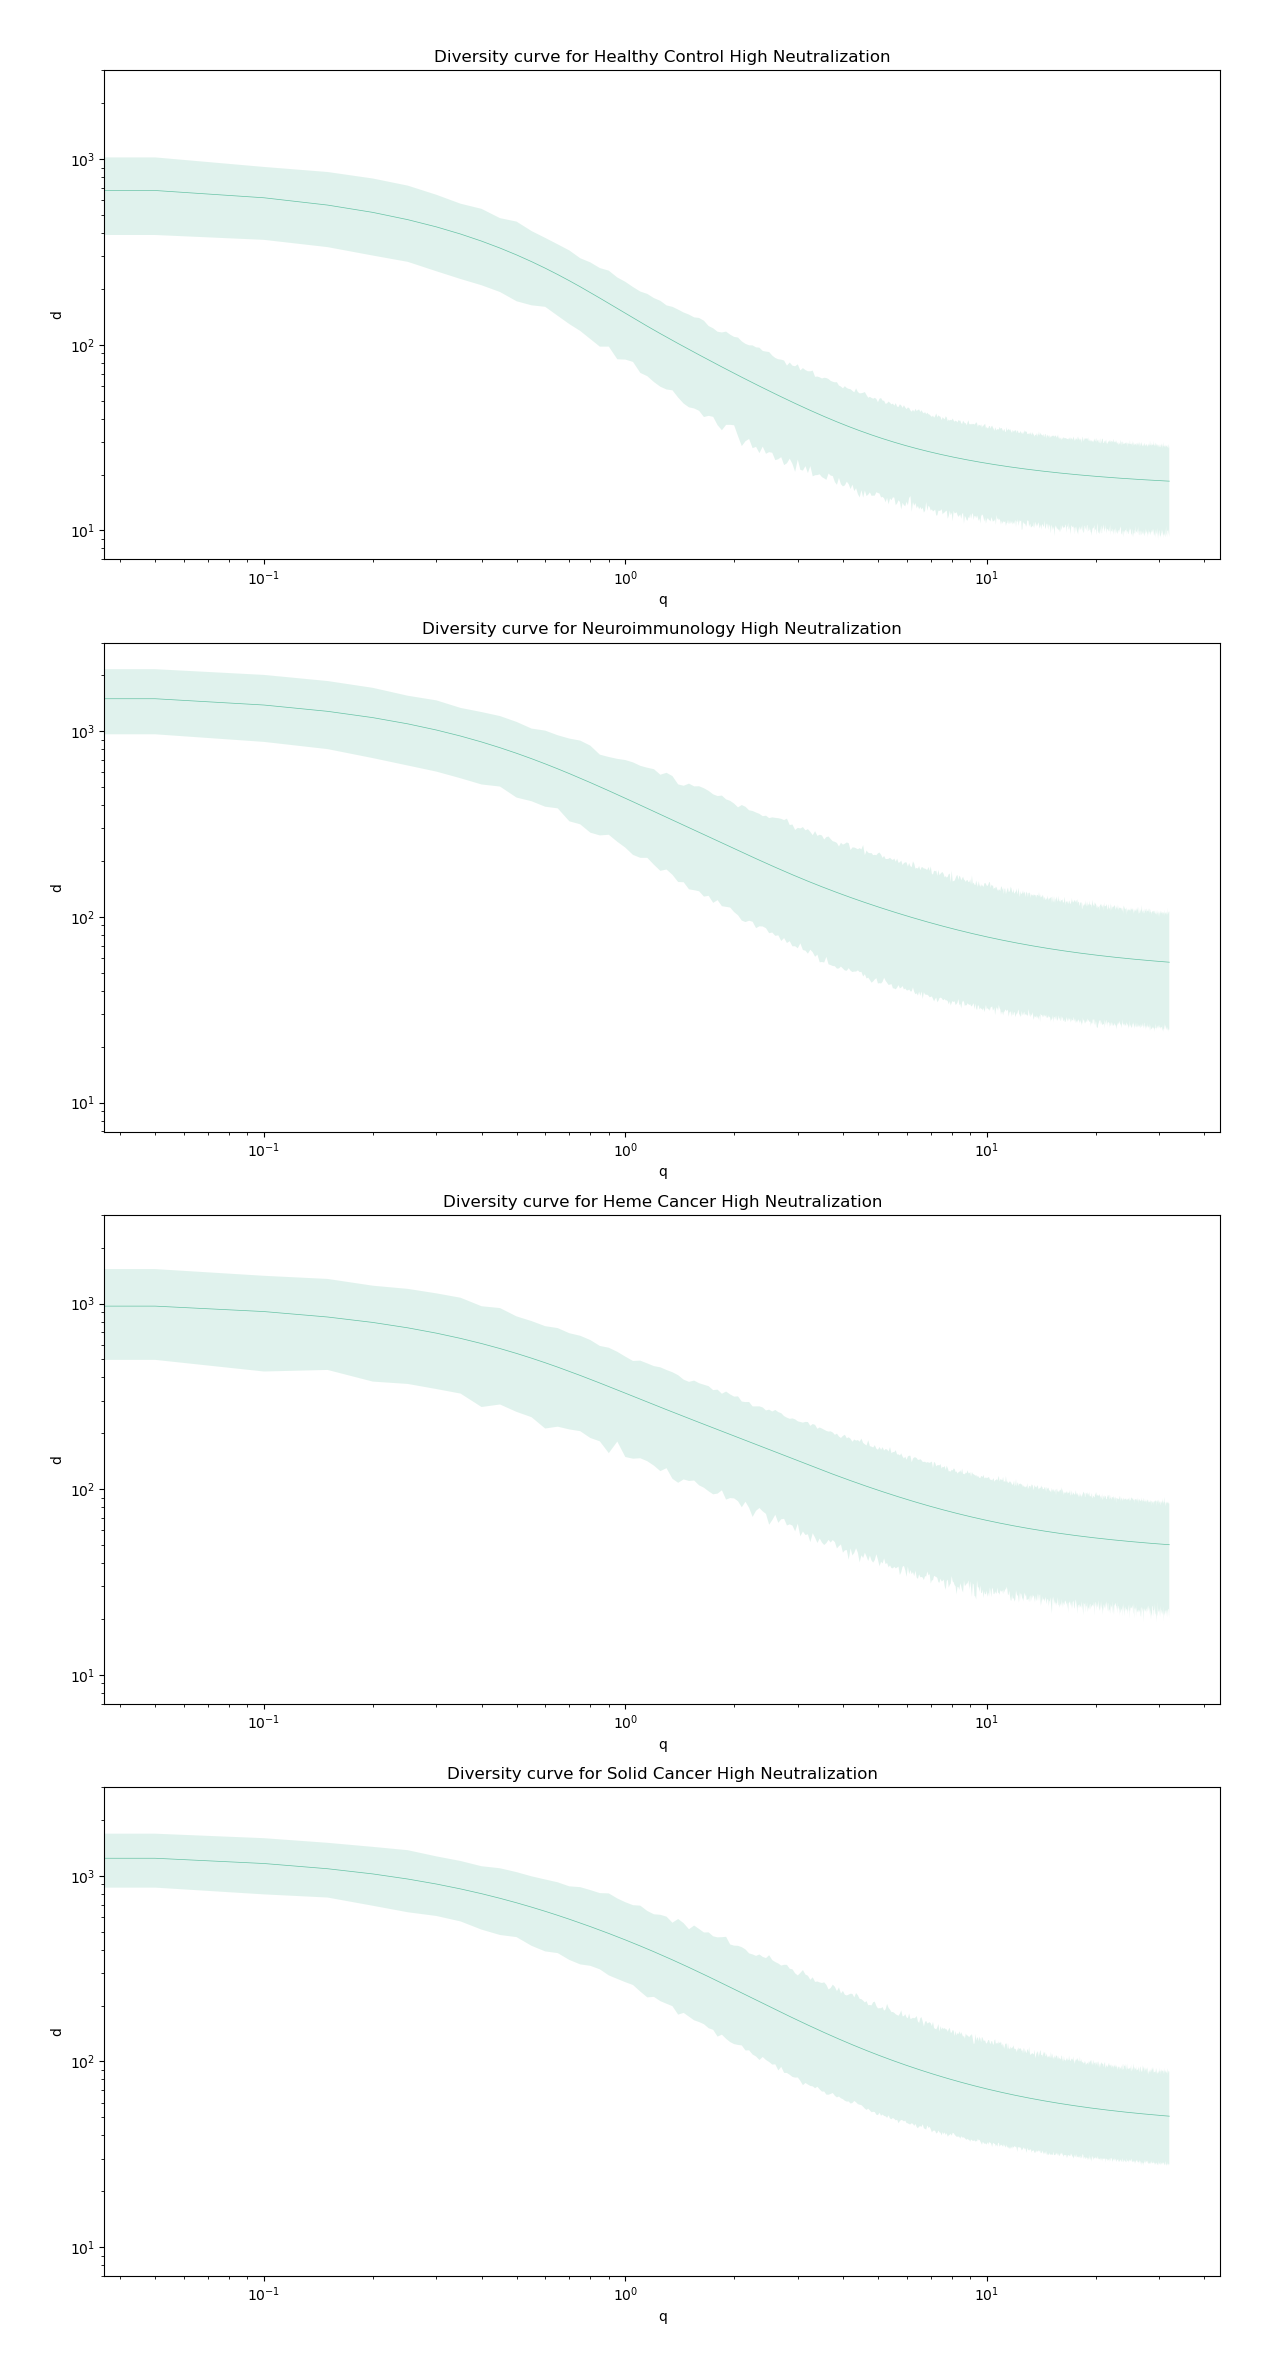

(<Figure size 1200x2400 with 4 Axes>,
 (<Axes: title={'center': 'Diversity curve for Healthy Control High Neutralization'}, xlabel='q', ylabel='d'>,
  <Axes: title={'center': 'Diversity curve for Neuroimmunology High Neutralization'}, xlabel='q', ylabel='d'>,
  <Axes: title={'center': 'Diversity curve for Heme Cancer High Neutralization'}, xlabel='q', ylabel='d'>,
  <Axes: title={'center': 'Diversity curve for Solid Cancer High Neutralization'}, xlabel='q', ylabel='d'>))

In [12]:
hue='condition'

dfs = []
for i, (group_id, group_name) in enumerate(diag_hi_groups):
        
    df = br.load_diversity_group_data(
        data_dir=repcalc_dir,
        repertoire_group=repertoire_groups[group_id],
        processing_stage='igblast.makedb.gene.clone'
    )
    dfs.append(df)
df = pd.concat(dfs)

def plot1(ax):
    group_name = 'Healthy Control High Neutralization'
    gr.plot_diversity_curve(
        df=df[df['condition']==group_name].copy(),
        title=f'Diversity curve for {group_name}',
        hue=hue,
        ax=ax,
        legend=False
    )

def plot2(ax):
    group_name = 'Neuroimmunology High Neutralization'
    gr.plot_diversity_curve(
        df=df[df['condition']==group_name].copy(),
        title=f'Diversity curve for {group_name}',
        hue=hue,
        ax=ax,
        legend=False
    )
def plot3(ax):
    group_name = 'Heme Cancer High Neutralization'
    gr.plot_diversity_curve(
        df=df[df['condition']==group_name].copy(),
        title=f'Diversity curve for {group_name}',
        hue=hue,
        ax=ax,
        legend=False
    )
def plot4(ax):
    group_name = 'Solid Cancer High Neutralization'
    ax = gr.plot_diversity_curve(
        df=df[df['condition']==group_name].copy(),
        title=f'Diversity curve for {group_name}',
        hue=hue,
        ax=ax,
        legend=False
    )

plot_four_vertical_layout(plot1, plot2, plot3, plot4, figsize=(12,24), sharey=True)

## SHM Hedgehog plots

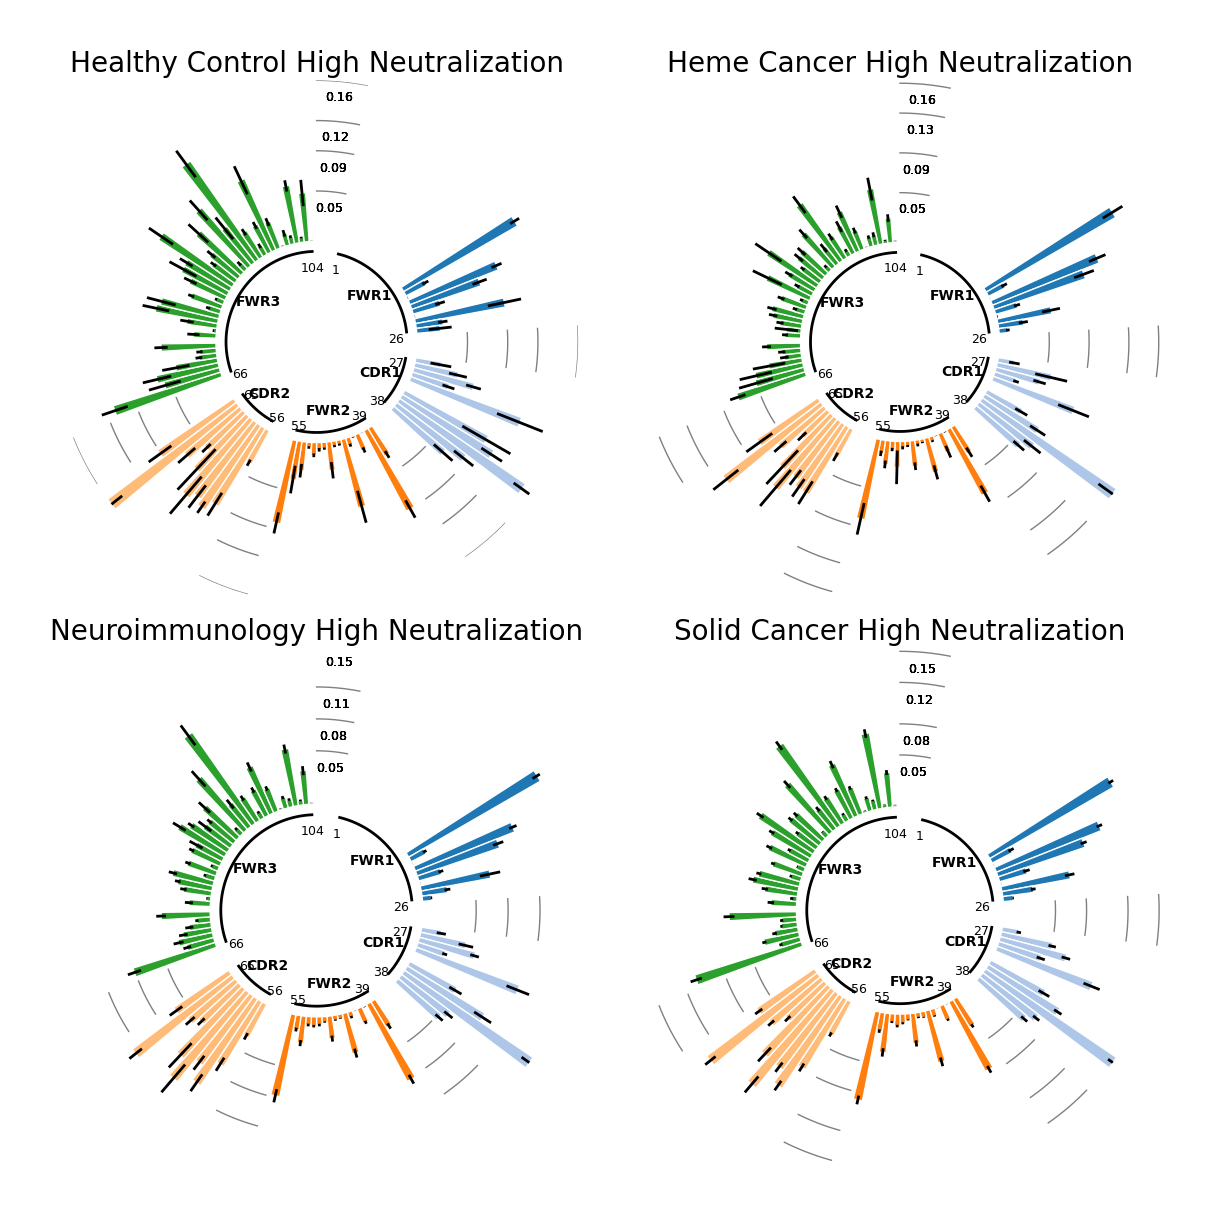

(<Figure size 1200x1200 with 4 Axes>,
 (<PolarAxes: title={'center': 'Healthy Control High Neutralization'}>,
  <PolarAxes: title={'center': 'Heme Cancer High Neutralization'}>,
  <PolarAxes: title={'center': 'Neuroimmunology High Neutralization'}>,
  <PolarAxes: title={'center': 'Solid Cancer High Neutralization'}>))

In [ ]:
def plot_top_left(ax):
    df = br.load_and_prepare_mutation_data(
        mutation_data_dir=repcalc_dir,
        group_id=diag_hi_groups[0][0],
        trim_codons=16,
        processing_stage='igblast.makedb.gene.clone.mutations'
    )
    
    gr.plot_mutational_hedgehog(
        df=df,
        figsize=(12,12),
        title=f'{diag_hi_groups[0][1]}',
        ax=ax
    )
def plot_top_right(ax):
    df = br.load_and_prepare_mutation_data(
        mutation_data_dir=repcalc_dir,
        group_id=diag_hi_groups[1][0],
        trim_codons=16,
        processing_stage='igblast.makedb.gene.clone.mutations'
    )
    
    gr.plot_mutational_hedgehog(
        df=df,
        figsize=(12,12),
        title=f'{diag_hi_groups[1][1]}',
        ax=ax
    )
def plot_bottom_left(ax):
    df = br.load_and_prepare_mutation_data(
        mutation_data_dir=repcalc_dir,
        group_id=diag_hi_groups[2][0],
        trim_codons=16,
        processing_stage='igblast.makedb.gene.clone.mutations'
    )
    
    gr.plot_mutational_hedgehog(
        df=df,
        figsize=(12,12),
        title=f'{diag_hi_groups[2][1]}',
        ax=ax
    )
def plot_bottom_right(ax):
    df = br.load_and_prepare_mutation_data(
        mutation_data_dir=repcalc_dir,
        group_id=diag_hi_groups[3][0],
        trim_codons=16,
        processing_stage='igblast.makedb.gene.clone.mutations'
    )
    
    gr.plot_mutational_hedgehog(
        df=df,
        figsize=(12,12),
        title=f'{diag_hi_groups[3][1]}',
        ax=ax
    )

plot_two_by_two_layout(
    plot_top_left, 
    plot_top_right, 
    plot_bottom_left, 
    plot_bottom_right, 
    figsize=(12, 12), 
    sharey=False, 
    suptitle=None, 
    projection_top_left='polar',
    projection_top_right='polar',
    projection_bottom_left='polar',
    projection_bottom_right='polar')

In [ ]:
# for group_id, group_name in diag_hi_groups:
#     df = br.load_and_prepare_mutation_data(
#         mutation_data_dir=repcalc_dir,
#         group_id=group_id,
#         trim_codons=16,
#         processing_stage='igblast.makedb.gene.clone.mutations'
#     )
#     # print(df)
#     fig, ax = gr.plot_mutational_hedgehog(
#         df=df,
#         figsize=(12,12),
#         title=f'Mutational HedgeHog for group: {group_name}',
#     )

#     fig.show()

## Chord Diagram

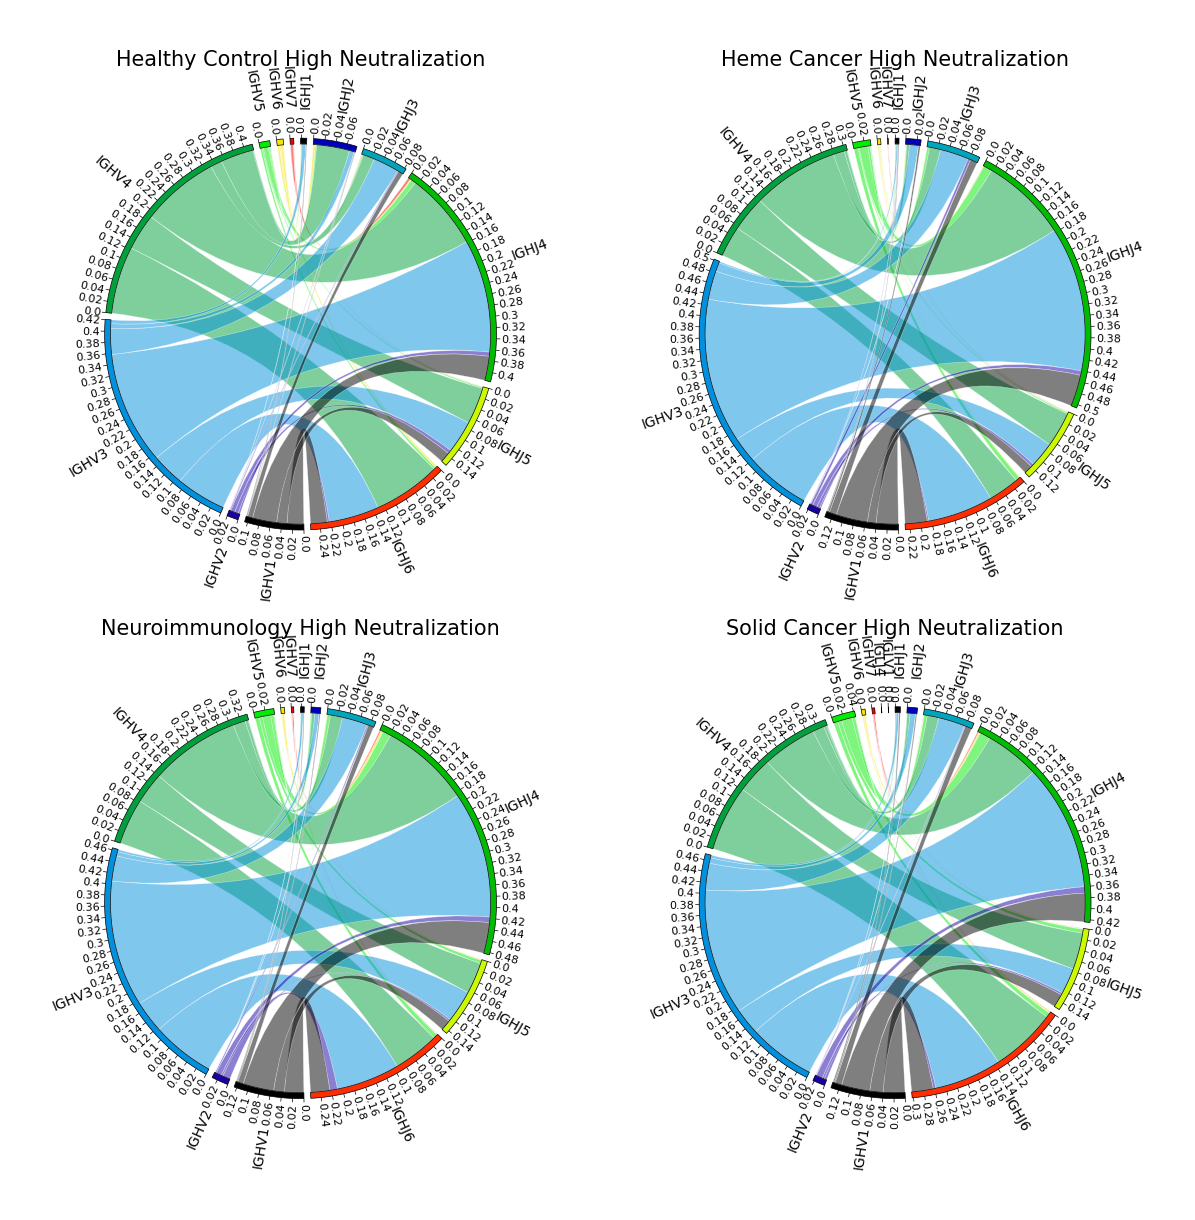

In [16]:
def plot_top_left(ax):
    df = br.load_and_prepare_data_vj_combo(
        repcalc_dir=repcalc_dir,
        group_id=diag_hi_groups[0][0],
        combo_type='vj_combo',
        processing_stage='.igblast.makedb.gene.clone.group.'
    )

    gr.plot_vj_chord_diagram(
        df=df,
        freq_col='duplicate_frequency_avg',
        ticks_interval=0.02,
        max_links=None,
        cmap=v_subgroup_cmap | j_subgroup_cmap,
        title=diag_hi_groups[0][1],
        ax=ax
    )
def plot_top_right(ax):
    df = br.load_and_prepare_data_vj_combo(
        repcalc_dir=repcalc_dir,
        group_id=diag_hi_groups[1][0],
        combo_type='vj_combo',
        processing_stage='.igblast.makedb.gene.clone.group.'
    )

    gr.plot_vj_chord_diagram(
        df=df,
        freq_col='duplicate_frequency_avg',
        ticks_interval=0.02,
        max_links=None,
        cmap=v_subgroup_cmap | j_subgroup_cmap,
        title=diag_hi_groups[1][1],
        ax=ax
    )
def plot_bottom_left(ax):
    df = br.load_and_prepare_data_vj_combo(
        repcalc_dir=repcalc_dir,
        group_id=diag_hi_groups[2][0],
        combo_type='vj_combo',
        processing_stage='.igblast.makedb.gene.clone.group.'
    )

    gr.plot_vj_chord_diagram(
        df=df,
        freq_col='duplicate_frequency_avg',
        ticks_interval=0.02,
        max_links=None,
        cmap=v_subgroup_cmap | j_subgroup_cmap,
        title=diag_hi_groups[2][1],
        ax=ax
    )
def plot_bottom_right(ax):
    df = br.load_and_prepare_data_vj_combo(
        repcalc_dir=repcalc_dir,
        group_id=diag_hi_groups[3][0],
        combo_type='vj_combo',
        processing_stage='.igblast.makedb.gene.clone.group.'
    )

    gr.plot_vj_chord_diagram(
        df=df,
        freq_col='duplicate_frequency_avg',
        ticks_interval=0.02,
        max_links=None,
        cmap=v_subgroup_cmap | j_subgroup_cmap,
        title=diag_hi_groups[3][1],
        ax=ax
    )

fig, (ax1, ax2, ax3, ax4) = plot_two_by_two_layout(
    plot_top_left, 
    plot_top_right, 
    plot_bottom_left, 
    plot_bottom_right, 
    figsize=(12, 12), 
    sharey=False, 
    suptitle=None, 
    projection_top_left='polar',
    projection_top_right='polar',
    projection_bottom_left='polar',
    projection_bottom_right='polar'
)

fig.show()

In [ ]:
# df = br.load_and_prepare_data_vj_combo(
#     repcalc_dir=repcalc_dir,
#     group_id=diag_hi_groups[0][0],
#     combo_type='vj_combo',
#     processing_stage='.igblast.makedb.gene.clone.group.'
# )

# gr.plot_vj_chord_diagram(
#     df=df,
#     freq_col='duplicate_frequency_avg',
#     ticks_interval=0.02,
#     max_links=None,
#     cmap=v_subgroup_cmap | j_subgroup_cmap,
#     title=diag_hi_groups[0][1]+' VJ Chord Diagram',
#     ax=ax
# )